In [1290]:
import random
import pandas as pd
import networkx as nx
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



import spacy, nltk, gensim, sklearn
import os, codecs, string, random
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from operator import itemgetter
import collections
from networkx.algorithms.community.centrality import girvan_newman

import itertools


%matplotlib inline

DATA_FOLDER = './ADA_personal/data/'

HAPPINESS_DATASET = DATA_FOLDER+"happiness2020.csv"
COUNTRIES_DATASET = DATA_FOLDER+"countries_info.csv"

In [1022]:
happiness = pd.read_csv(HAPPINESS_DATASET)
happiness.head()

country  happiness_score  social_support  healthy_life_expectancy  \
0  Afghanistan           2.5669        0.470367                52.590000   
1      Albania           4.8827        0.671070                68.708138   
2      Algeria           5.0051        0.803385                65.905174   
3    Argentina           5.9747        0.900568                68.803802   
4      Armenia           4.6768        0.757479                66.750656   

   freedom_of_choices  generosity  perception_of_corruption  \
0            0.396573   -0.096429                  0.933687   
1            0.781994   -0.042309                  0.896304   
2            0.466611   -0.121105                  0.735485   
3            0.831132   -0.194914                  0.842010   
4            0.712018   -0.138780                  0.773545   

                         world_region  
0                          South Asia  
1          Central and Eastern Europe  
2        Middle East and North Africa  
3         Latin America and Caribbean  
4  Commonwealth of Independent States

In [1023]:
countries = pd.read_csv(COUNTRIES_DATASET, decimal=',')
countries.head()

country_name     area  population  literacy
0  afghanistan   647500    31056997      36.0
1      albania    28748     3581655      86.5
2      algeria  2381740    32930091      70.0
3    argentina  2766890    39921833      97.1
4      armenia    29800     2976372      98.6

In [1024]:
happiness['country_name'] = happiness['country'].apply(lambda r: r.lower())
country_features = happiness.merge(countries, on="country_name").drop("country_name", axis=1)
country_features.head()

country  happiness_score  social_support  healthy_life_expectancy  \
0  Afghanistan           2.5669        0.470367                52.590000   
1      Albania           4.8827        0.671070                68.708138   
2      Algeria           5.0051        0.803385                65.905174   
3    Argentina           5.9747        0.900568                68.803802   
4      Armenia           4.6768        0.757479                66.750656   

   freedom_of_choices  generosity  perception_of_corruption  \
0            0.396573   -0.096429                  0.933687   
1            0.781994   -0.042309                  0.896304   
2            0.466611   -0.121105                  0.735485   
3            0.831132   -0.194914                  0.842010   
4            0.712018   -0.138780                  0.773545   

                         world_region     area  population  literacy  
0                          South Asia   647500    31056997      36.0  
1          Central and Eastern Europe    28748     3581655      86.5  
2        Middle East and North Africa  2381740    32930091      70.0  
3         Latin America and Caribbean  2766890    39921833      97.1  
4  Commonwealth of Independent States    29800     2976372      98.6

In [1025]:
print("happiness = {}".format(len(happiness)))
print("countries = {}".format(len(countries)))
print("country_features = {}".format(len(country_features)))

len(happiness) == len(countries) == len(country_features)

happiness = 135
countries = 135
country_features = 135


True

In [1026]:
country_features.sort_values("happiness_score", ascending=False)[['country', 'happiness_score']].head(10)

country  happiness_score
38       Finland           7.8087
31       Denmark           7.6456
115  Switzerland           7.5599
50       Iceland           7.5045
92        Norway           7.4880
87   Netherlands           7.4489
114       Sweden           7.3535
88   New Zealand           7.2996
6        Austria           7.2942
72    Luxembourg           7.2375

In [1027]:
average_by_region = country_features.groupby("world_region")['happiness_score'].agg(['mean','size'])
average_by_region.sort_values("mean", ascending=False)

mean  size
world_region                                      
North America and ANZ               7.173525     4
Western Europe                      6.967405    20
Latin America and Caribbean         5.971280    20
Central and Eastern Europe          5.891393    14
Southeast Asia                      5.517788     8
East Asia                           5.483633     3
Commonwealth of Independent States  5.358342    12
Middle East and North Africa        5.269306    16
Sub-Saharan Africa                  4.393856    32
South Asia                          4.355083     6

In [1028]:
country_features[country_features.world_region=='North America and ANZ'][['country', 'happiness_score']]

country  happiness_score
5        Australia           7.2228
21          Canada           7.2321
88     New Zealand           7.2996
127  United States           6.9396

In [1029]:
for idx, row in country_features[country_features.literacy==100].iterrows():
    print("{} - {} ({})".format(row.world_region, row.country, row.happiness_score))

North America and ANZ - Australia (7.222799778)
Western Europe - Denmark (7.645599842)
Western Europe - Finland (7.808700085)
Western Europe - Luxembourg (7.237500191)
Western Europe - Norway (7.487999916000001)


In [1030]:
country_features.literacy.mean()

81.85112781954888

In [1031]:
percentage = len(country_features[country_features.literacy<50])/len(country_features)
print("Percentage of countries with literacy level < 50%: {:.2%}".format(percentage))

Percentage of countries with literacy level < 50%: 11.85%


In [1032]:
illiterate_people = country_features.population * (100 - country_features.literacy)/100
illiterate_fraction = illiterate_people.sum() / country_features.population.sum()

print("Illiterate people: {:.0f} ({:.2%})".format(illiterate_people.sum(), illiterate_fraction))

Illiterate people: 1249372988 (20.33%)


In [1033]:
country_features["population_density"] = country_features['population']/country_features['area']
country_features.head()

country  happiness_score  social_support  healthy_life_expectancy  \
0  Afghanistan           2.5669        0.470367                52.590000   
1      Albania           4.8827        0.671070                68.708138   
2      Algeria           5.0051        0.803385                65.905174   
3    Argentina           5.9747        0.900568                68.803802   
4      Armenia           4.6768        0.757479                66.750656   

   freedom_of_choices  generosity  perception_of_corruption  \
0            0.396573   -0.096429                  0.933687   
1            0.781994   -0.042309                  0.896304   
2            0.466611   -0.121105                  0.735485   
3            0.831132   -0.194914                  0.842010   
4            0.712018   -0.138780                  0.773545   

                         world_region     area  population  literacy  \
0                          South Asia   647500    31056997      36.0   
1          Central and Eastern Europe    28748     3581655      86.5   
2        Middle East and North Africa  2381740    32930091      70.0   
3         Latin America and Caribbean  2766890    39921833      97.1   
4  Commonwealth of Independent States    29800     2976372      98.6   

   population_density  
0           47.964474  
1          124.587971  
2           13.826065  
3           14.428413  
4           99.878255

In [1034]:
country_features.sort_values("population_density", ascending=True)[['country', 'happiness_score']].head(3)

country  happiness_score
83   Mongolia           5.4562
5   Australia           7.2228
14   Botswana           3.4789

<AxesSubplot: xlabel='happiness_score', ylabel='healthy_life_expectancy'>

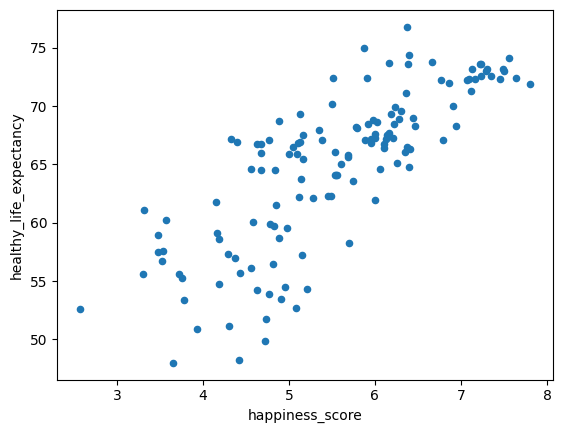

In [1035]:
country_features.plot(x="happiness_score", y="healthy_life_expectancy", kind="scatter")

In [1036]:
# Let's load necessary libraries and the datasets
# "pip install seaborn" if necessary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

data_folder = './ADA_personal/data/'


movies = pd.read_csv(data_folder+'blockbusters.csv')
movies['worldwide_gross'] = movies['worldwide_gross'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)

commune_pop = pd.read_excel(data_folder+'communes_pop.xls',skiprows=5,skipfooter=7,
                            sheet_name='2017',names=['commune','population_Jan',
                                                     'birth_alive','death','natrual_increase',
                                                     'arrivals','departure','migratory_balance',
                                                     'divergence_statistic','population_Dec','variation_num',
                                                     'variation_ratio'])

pop_per_commune = commune_pop[[name.startswith('......') for name in commune_pop.commune]].copy()

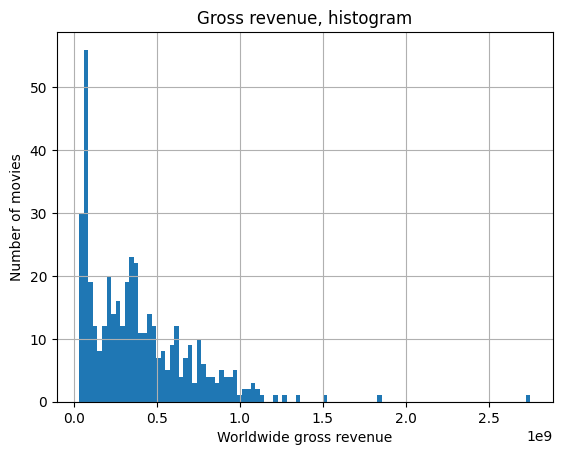

In [1037]:
#we use pandas wrapper
movies['worldwide_gross'].hist(bins = 100)

#alternatively, we can use matplotlib directly
#plt.hist(movies['worldwide_gross'].values, bins = 100)

plt.xlabel('Worldwide gross revenue')
plt.ylabel('Number of movies')
plt.title('Gross revenue, histogram');

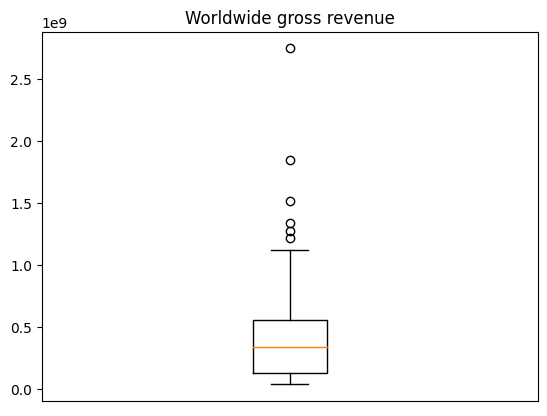

In [1038]:
plt.boxplot(movies['worldwide_gross'])
plt.xticks([])
plt.title('Worldwide gross revenue');

Text(0, 0.5, 'IMDB rating')

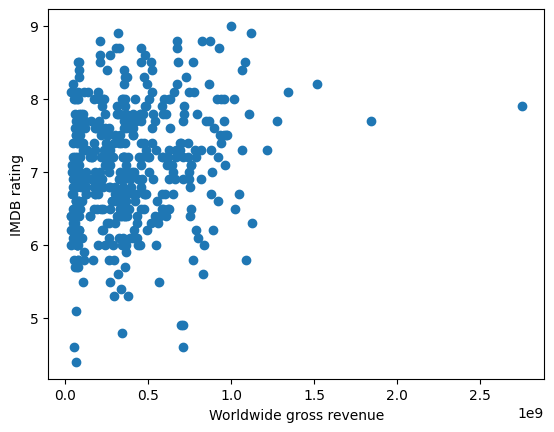

In [1039]:
plt.scatter(movies['worldwide_gross'], movies['imdb_rating'])

plt.xlabel('Worldwide gross revenue')
plt.ylabel('IMDB rating')

Text(0, 0.5, 'IMDB rating')

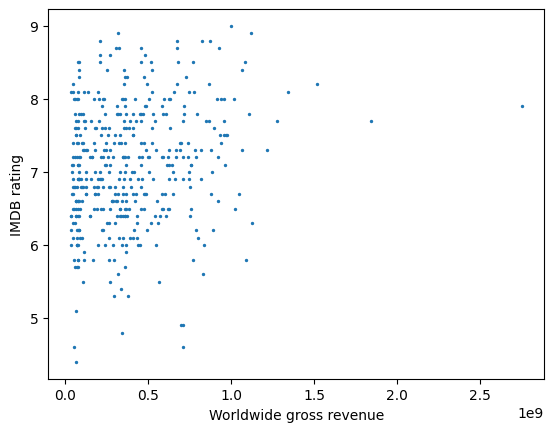

In [1040]:
plt.scatter(movies['worldwide_gross'], movies['imdb_rating'], s = 2)

plt.xlabel('Worldwide gross revenue')
plt.ylabel('IMDB rating')

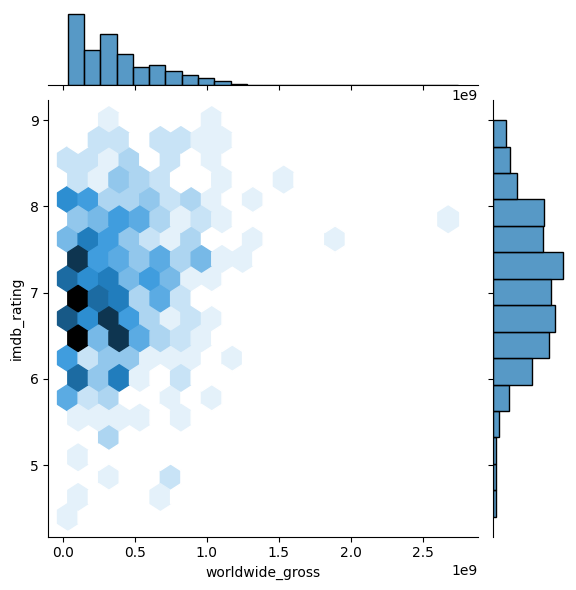

In [1041]:
sns.jointplot(x=movies['worldwide_gross'], y=movies['imdb_rating'], kind="hex")

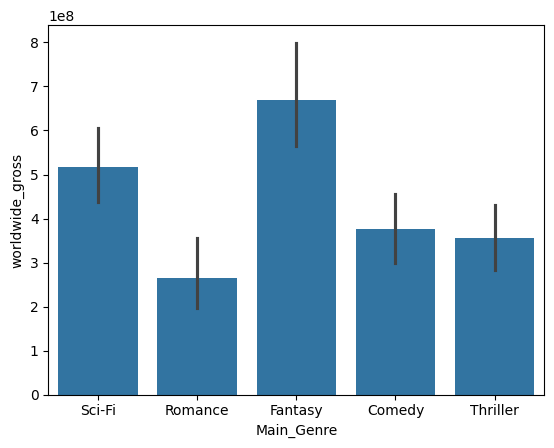

In [1042]:
ax = sns.barplot(x="Main_Genre", y="worldwide_gross", data=movies.loc[movies['Main_Genre'].isin(['Thriller','Comedy',
                                                                                      'Fantasy','Sci-Fi','Romance'])])

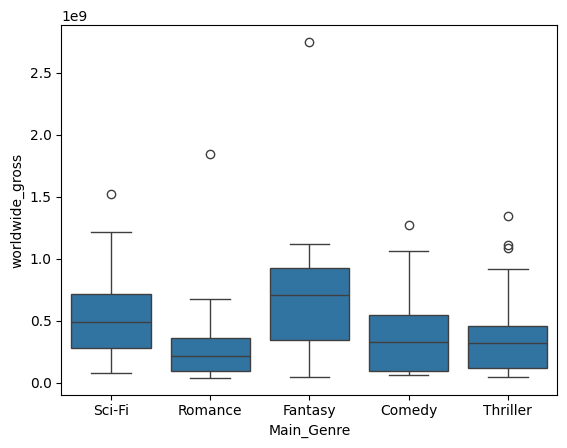

In [1043]:
ax = sns.boxplot(x="Main_Genre", y="worldwide_gross", data=movies.loc[movies['Main_Genre'].isin(['Thriller','Comedy',
                                                                                      'Fantasy','Sci-Fi','Romance'])])

In [1044]:
# Calculate yearly stats across movies here

stats_by_year = movies.groupby(movies['year']).apply(lambda x: pd.Series({
        'average_worldwide_gross': x['worldwide_gross'].mean(),
        'std_dev_worldwide_gross': x['worldwide_gross'].std()
    }))

/var/folders/lx/78bdvyf1797_dxpw5r160s9c0000gn/T/ipykernel_2610/1428866457.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_by_year = movies.groupby(movies['year']).apply(lambda x: pd.Series({


Text(0, 0.5, 'Worldwide gross revenue')

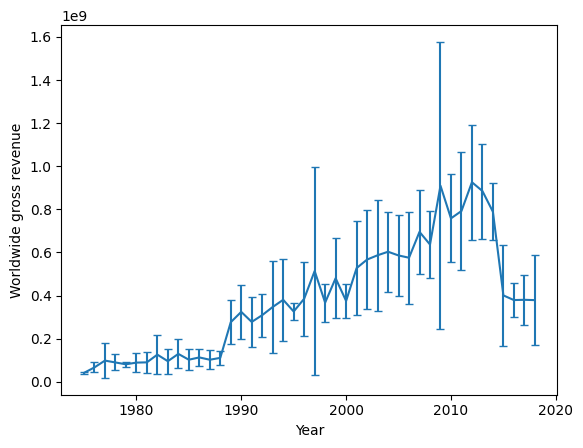

In [1045]:
# Write your code to make plot with errorbars here

plt.errorbar(stats_by_year.index, stats_by_year.average_worldwide_gross,
             yerr = stats_by_year.std_dev_worldwide_gross,
             capsize= 3)
plt.xlabel('Year')
plt.ylabel('Worldwide gross revenue')

Text(0, 0.5, 'Worldwide gross revenue')

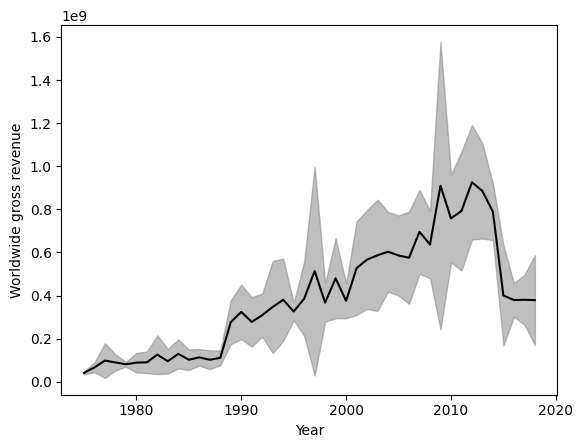

In [1046]:
# Write your code to make filled plot here

plt.fill_between(stats_by_year.index, stats_by_year.average_worldwide_gross - stats_by_year.std_dev_worldwide_gross,
                 stats_by_year.average_worldwide_gross + stats_by_year.std_dev_worldwide_gross, alpha = 0.5, color = 'gray')
plt.plot(stats_by_year.average_worldwide_gross, color = 'black')

plt.xlabel('Year')
plt.ylabel('Worldwide gross revenue')

In [1047]:
# Calculate stats by genre here

stats_by_genre = movies.groupby('Main_Genre').apply(lambda x: pd.Series({
        'length': x['length'].values
    }))

/var/folders/lx/78bdvyf1797_dxpw5r160s9c0000gn/T/ipykernel_2610/2133200921.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_by_genre = movies.groupby('Main_Genre').apply(lambda x: pd.Series({


<AxesSubplot: xlabel='Genre_2', ylabel='Main_Genre'>

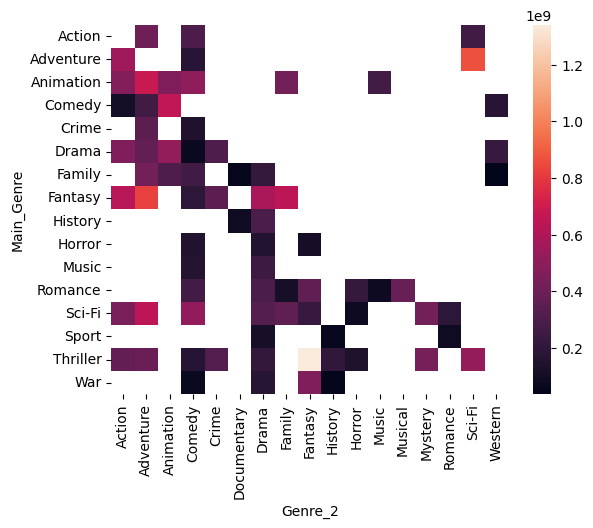

In [1048]:
# Write your code to make the second heatmap here

df3 = pd.crosstab(movies['Main_Genre'],movies['Genre_2'], values = movies['worldwide_gross'],
                  margins=False, aggfunc='mean')

sns.heatmap(df3, annot=False)

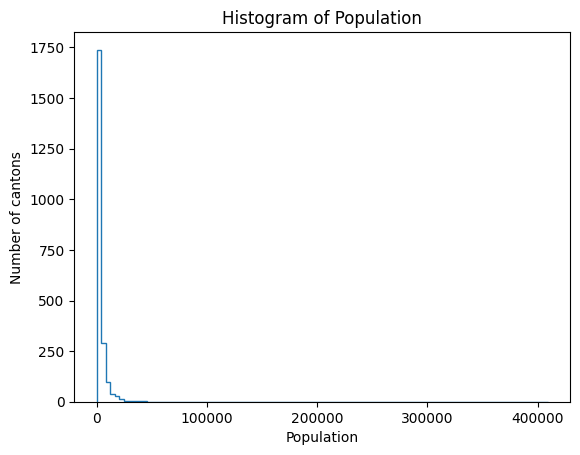

In [1049]:
# Write your code here

#plot out the histogram of population Counts in December
plt.hist(pop_per_commune.population_Dec,bins=100,histtype='step')
plt.title('Histogram of Population')
plt.ylabel('Number of cantons')
plt.xlabel('Population')
plt.show()

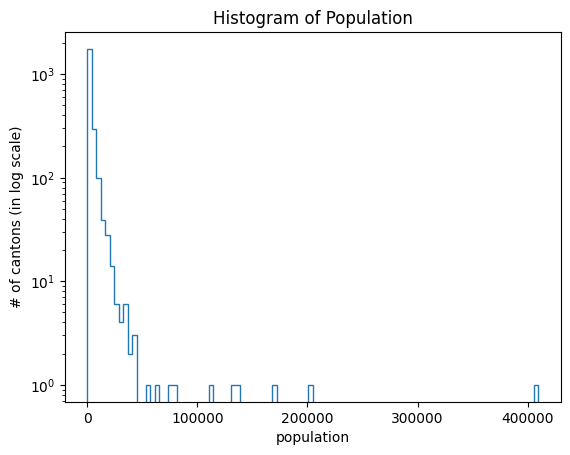

In [1050]:
# Write your code here

array_100 = plt.hist(pop_per_commune.population_Dec,bins=100,log=True,histtype='step')
plt.title('Histogram of Population')
plt.ylabel('# of cantons (in log scale)')
plt.xlabel('population')
plt.show()

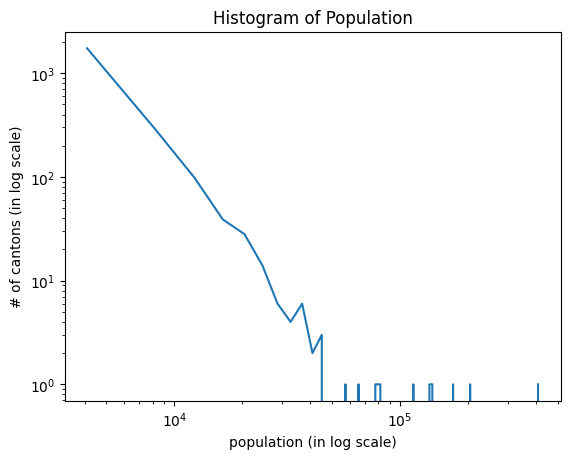

In [1051]:
plt.loglog(array_100[1][1:],array_100[0])
plt.title('Histogram of Population')
plt.ylabel('# of cantons (in log scale)')
plt.xlabel('population (in log scale)')
plt.show()

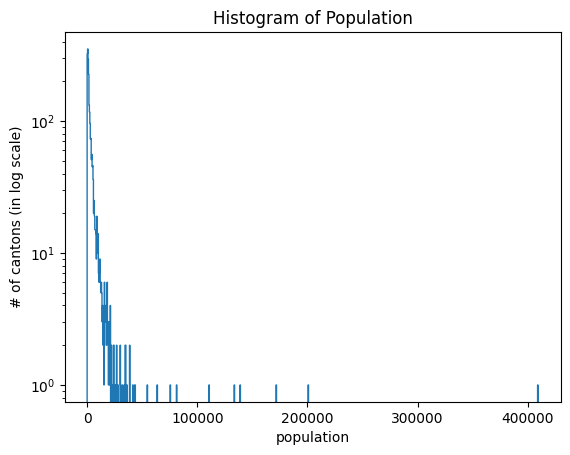

In [1052]:
array_1000 = plt.hist(pop_per_commune.population_Dec,bins=1000,log=True,histtype='step')
plt.title('Histogram of Population')
plt.ylabel('# of cantons (in log scale)')
plt.xlabel('population')
plt.show()

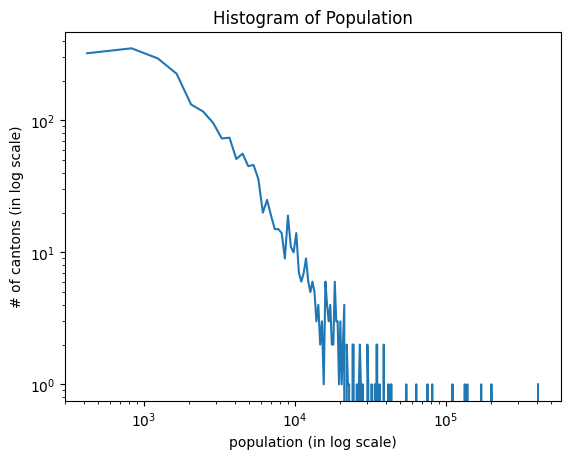

In [1053]:
plt.loglog(array_1000[1][1:],array_1000[0])
plt.title('Histogram of Population')
plt.ylabel('# of cantons (in log scale)')
plt.xlabel('population (in log scale)')
plt.show()

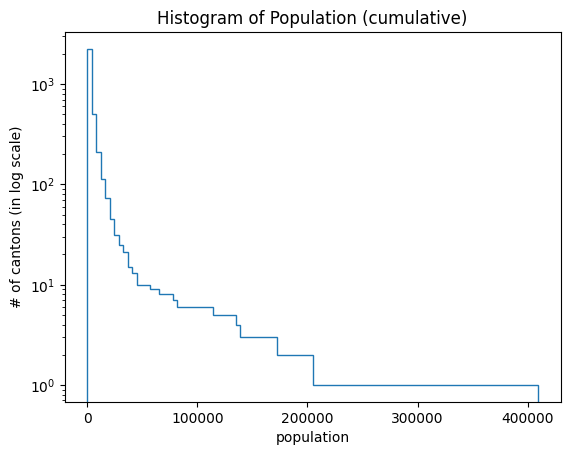

In [1054]:
array_cumulative=plt.hist(pop_per_commune.population_Dec,bins=100,log=True,cumulative=-1,histtype='step')
plt.title('Histogram of Population (cumulative)')
plt.ylabel('# of cantons (in log scale)')
plt.xlabel('population')
plt.show()

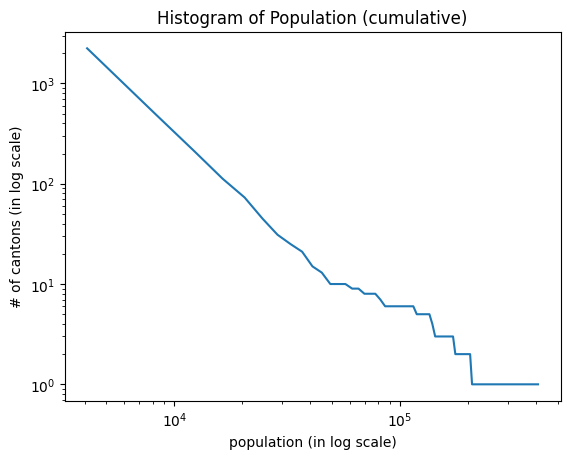

In [1055]:
plt.loglog(array_cumulative[1][1:],array_cumulative[0])
plt.title('Histogram of Population (cumulative)')
plt.ylabel('# of cantons (in log scale)')
plt.xlabel('population (in log scale)')
plt.show()


In [1056]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.close('all')  # Close any figures that might be open
import seaborn as sns
import math

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats

In [1057]:
data_folder = './ADA_personal/data/'
df = pd.read_csv(data_folder + 'acs2015_county_data.csv')

In [1058]:
df.columns

Index(['CensusId', 'State', 'County', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Citizen', 'Income',
       'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment'],
      dtype='object')

In [1059]:
df.sample(10)

CensusId           State   County  TotalPop     Men   Women  Hispanic  \
1964     37149  North Carolina     Polk     20327    9808   10519       5.7   
935      20095          Kansas  Kingman      7790    3926    3864       3.0   
2024     38069    North Dakota   Pierce      4395    2220    2175       1.1   
456      13141         Georgia  Hancock      8881    4878    4003       1.9   
1664     31021        Nebraska     Burt      6647    3273    3374       2.8   
431      13091         Georgia    Dodge     21180   11215    9965       3.5   
835      19093            Iowa      Ida      7071    3561    3510       1.9   
21        1043         Alabama  Cullman     80965   40081   40884       4.3   
847      19117            Iowa    Lucas      8731    4376    4355       0.3   
430      13089         Georgia   DeKalb    716331  341362  374969       9.1   

      White  Black  Native  ...  Walk  OtherTransp  WorkAtHome  MeanCommute  \
1964   88.1    5.1     0.1  ...   1.6          2.0         6.2         25.0   
935    94.2    0.1     0.9  ...   5.1          3.3         6.7         21.9   
2024   95.7    0.5     1.9  ...   8.2          0.2         4.9         14.0   
456    24.0   73.2     0.0  ...   1.7          0.7         2.0         27.7   
1664   93.8    1.0     1.2  ...   3.3          0.7         6.5         22.3   
431    65.1   28.5     0.0  ...   1.1          5.9         1.5         24.3   
835    96.2    0.5     0.4  ...   4.4          1.8         7.2         15.7   
21     92.2    1.1     0.4  ...   1.5          1.0         2.6         26.4   
847    97.4    0.2     0.3  ...   2.0          1.2         6.4         22.4   
430    29.7   53.0     0.2  ...   1.8          1.5         5.5         31.4   

      Employed  PrivateWork  PublicWork  SelfEmployed  FamilyWork  \
1964      8270         76.8        12.6          10.5         0.1   
935       3509         69.7        14.6          15.6         0.1   
2024      2194         72.4         8.9          18.4         0.3   
456       2159         64.8        29.5           5.7         0.0   
1664      3046         75.5        14.1           9.6         0.8   
431       7871         60.0        31.7           8.3         0.1   
835       3579         79.7        10.9           9.3         0.1   
21       32282         81.6        12.2           5.8         0.4   
847       4122         74.2        14.7          11.1         0.0   
430     344876         80.6        14.3           5.0         0.2   

      Unemployment  
1964           8.8  
935            5.7  
2024           0.9  
456           14.6  
1664           3.3  
431            9.8  
835            3.7  
21             7.3  
847            5.8  
430           11.3  

[10 rows x 37 columns]

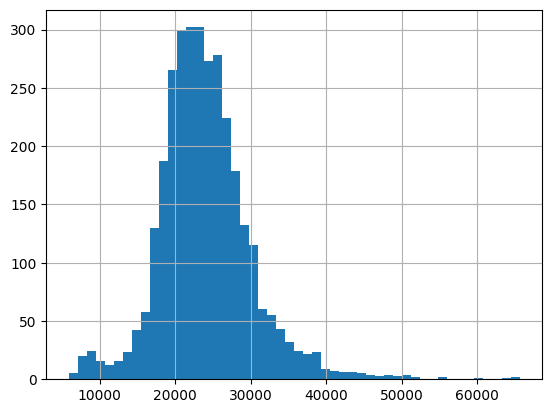

In [1060]:
df['IncomePerCap'].hist(bins = 50)
plt.show()

In [1061]:
df['IncomePerCap'].describe()

count     3220.000000
mean     23981.771739
std       6204.339960
min       5878.000000
25%      20238.500000
50%      23460.000000
75%      27053.250000
max      65600.000000
Name: IncomePerCap, dtype: float64

In [1062]:
# does the data come from a normal distrbution?
diagnostic.kstest_normal(df['IncomePerCap'].values, dist = 'norm')

(0.0637621121184162, 0.0009999999999998899)

In [1063]:
#how about exponential?
diagnostic.kstest_normal(df['IncomePerCap'].values, dist = 'exp')

(0.433243770582646, 0.0009999999999998899)

In [1064]:
#make 10 samples with replacement
sample1_counties = df.sample(n = 10, replace = True)

#make 10 samples without replacement
sample1_counties = df.sample(n = 10, replace = False)

#sometimes we want to sample in an ublanaced way, so that we upsample datapoints of certain characteristic,
#and downsample the others. this can be acieved with weights parameter
#here we sample by upsampling counties with large population
sample2_counties = df.sample(n = 10, replace = False, weights = df['TotalPop'])

In [1065]:
#on avergage, the samples in the sample produce with reveighting now have higher population, as we wanted!
print(sample1_counties['TotalPop'].mean())
print(sample2_counties['TotalPop'].mean())

230611.8
1761544.6


In [1066]:
stats.pearsonr(df['IncomePerCap'],df['Employed'])

PearsonRResult(statistic=0.2646136320394489, pvalue=9.94221535423901e-53)

In [1067]:
stats.spearmanr(df['IncomePerCap'],df['Employed'])

SignificanceResult(statistic=0.30770631560595474, pvalue=1.415296431173735e-71)

In [1068]:
df.loc[df['State'] == 'New York']['IncomePerCap'].mean()

28189.75806451613

In [1069]:
df.loc[df['State'] == 'California']['IncomePerCap'].mean()

27902.603448275862

In [1070]:
stats.ttest_ind(df.loc[df['State'] == 'New York']['IncomePerCap'], df.loc[df['State'] == 'California']['IncomePerCap'])

TtestResult(statistic=0.19788117232375713, pvalue=0.8434785239169611, df=118.0)

(25000.0, 32000.0)

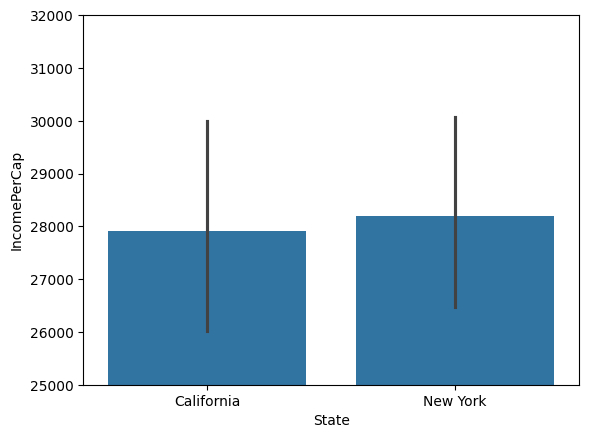

In [1071]:
ax = sns.barplot(x="State", y="IncomePerCap", data=df.loc[df['State'].isin(['New York','California'])])
plt.ylim([25000,32000])

Text(7.125000000000009, 0.5, 'Income per Capita [$]')

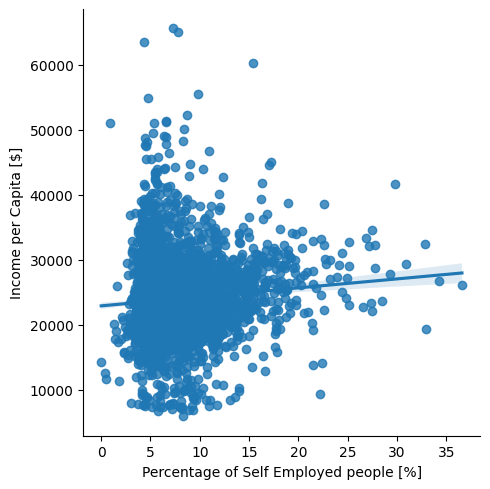

In [1072]:
import seaborn as sn

per_capita_self_empl = df[['State','IncomePerCap', 'SelfEmployed']]
sn.lmplot(x='SelfEmployed',y='IncomePerCap', data=per_capita_self_empl)
plt.xlabel("Percentage of Self Employed people [%]")
plt.ylabel("Income per Capita [$]")

(0.0, 22.0)

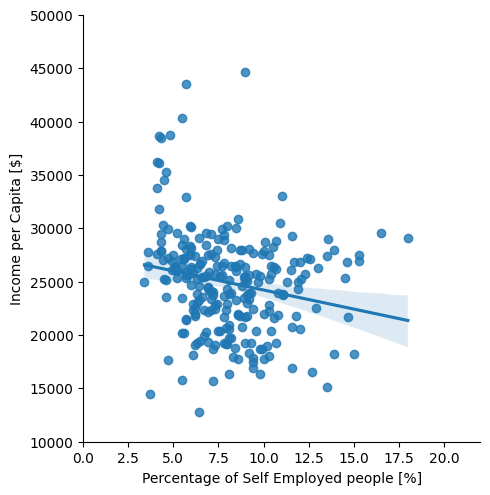

In [1073]:
SetA_per_capita_self_empl = per_capita_self_empl.query("State == 'Wisconsin' | \
                                                        State == 'Tennessee' | \
                                                        State == 'Minnesota' ") 

sn.lmplot(x='SelfEmployed',y='IncomePerCap', data=SetA_per_capita_self_empl)
plt.xlabel("Percentage of Self Employed people [%]")
plt.ylabel("Income per Capita [$]")
plt.ylim([10000,50000])
plt.xlim([0,22])

(0.0, 22.0)

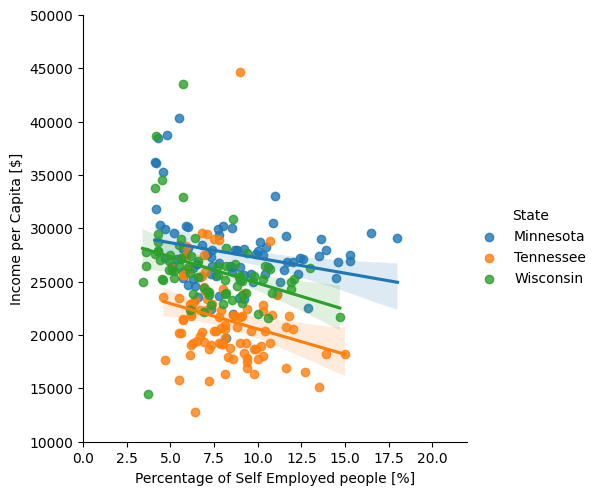

In [1074]:
sn.lmplot(x='SelfEmployed',y='IncomePerCap', data=SetA_per_capita_self_empl, hue = 'State')
plt.xlabel("Percentage of Self Employed people [%]")
plt.ylabel("Income per Capita [$]")
plt.ylim([10000,50000])
plt.xlim([0,22])

In [1075]:
Wisconsin_per_capita_self_empl = SetA_per_capita_self_empl.query("State == 'Wisconsin'") 
Tennessee_per_capita_self_empl = SetA_per_capita_self_empl.query("State == 'Tennessee'") 
Minnesota_per_capita_self_empl = SetA_per_capita_self_empl.query("State == 'Minnesota'") 

print(stats.pearsonr(Wisconsin_per_capita_self_empl['SelfEmployed'],Wisconsin_per_capita_self_empl['IncomePerCap']))
print(stats.pearsonr(Tennessee_per_capita_self_empl['SelfEmployed'],Tennessee_per_capita_self_empl['IncomePerCap']))
print(stats.pearsonr(Minnesota_per_capita_self_empl['SelfEmployed'],Minnesota_per_capita_self_empl['IncomePerCap']))

PearsonRResult(statistic=-0.32905300016378525, pvalue=0.004768134887745218)
PearsonRResult(statistic=-0.23836048684913153, pvalue=0.02001163195552819)
PearsonRResult(statistic=-0.2538551921654062, pvalue=0.017665199300911913)


(0.0, 25.0)

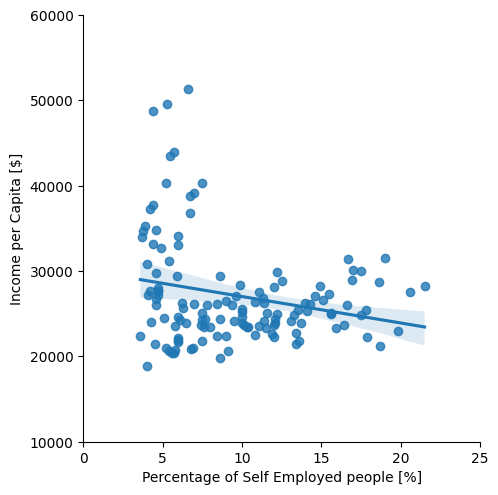

In [1076]:
SetB_per_capita_self_empl = per_capita_self_empl.query("State == 'New Jersey' | \
                                                        State == 'Kansas' | \
                                                        State == 'Rhode Island' ") 

sn.lmplot(x='SelfEmployed',y='IncomePerCap', data=SetB_per_capita_self_empl)
plt.xlabel("Percentage of Self Employed people [%]")
plt.ylabel("Income per Capita [$]")
plt.ylim([10000,60000])
plt.xlim([0,25])

In [1077]:
print(stats.pearsonr(SetB_per_capita_self_empl['SelfEmployed'],SetB_per_capita_self_empl['IncomePerCap']))

PearsonRResult(statistic=-0.2322214134608569, pvalue=0.007607493042857338)


(0.0, 25.0)

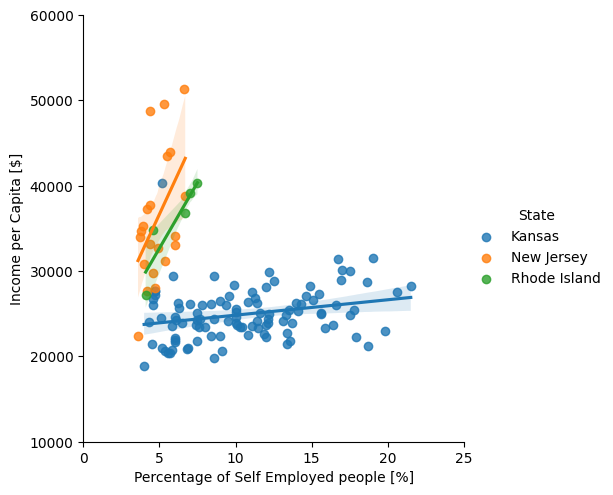

In [1078]:
sn.lmplot(x='SelfEmployed',y='IncomePerCap', data=SetB_per_capita_self_empl, hue = 'State')
plt.xlabel("Percentage of Self Employed people [%]")
plt.ylabel("Income per Capita [$]")
plt.ylim([10000,60000])
plt.xlim([0,25])

In [1079]:
NJ_per_capita_self_empl = SetB_per_capita_self_empl.query("State == 'New Jersey'") 
Kansas_per_capita_self_empl = SetB_per_capita_self_empl.query("State == 'Kansas'")
RI_per_capita_self_empl = SetB_per_capita_self_empl.query("State == 'Rhode Island'") 
print(stats.pearsonr(NJ_per_capita_self_empl['SelfEmployed'],NJ_per_capita_self_empl['IncomePerCap']))
print(stats.pearsonr(Kansas_per_capita_self_empl['SelfEmployed'],Kansas_per_capita_self_empl['IncomePerCap']))
print(stats.pearsonr(RI_per_capita_self_empl['SelfEmployed'],RI_per_capita_self_empl['IncomePerCap']))

PearsonRResult(statistic=0.4804478471336282, pvalue=0.027488944757806208)
PearsonRResult(statistic=0.2581029971443692, pvalue=0.007853351846832467)
PearsonRResult(statistic=0.9021788382149806, pvalue=0.03618310201575904)


In [1080]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [1081]:
data_folder = './ADA_personal/data/'
df = pd.read_csv(data_folder + 'heart_failure_clinical_records_dataset.csv')

In [1082]:
df.sample(10)

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
2    65.0        0                       146         0                 20   
113  70.0        1                       143         0                 60   
101  75.0        0                       582         0                 45   
165  80.0        0                       776         1                 38   
222  42.0        1                        86         0                 35   
125  43.0        1                       358         0                 50   
281  70.0        0                       582         0                 40   
225  75.0        0                       675         1                 60   
72   85.0        0                      5882         0                 35   
152  50.0        0                       115         0                 45   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
2                      0  162000.00              1.30           129    1   
113                    0  351000.00              1.30           137    0   
101                    1  263358.03              1.18           137    1   
165                    1  192000.00              1.30           135    0   
222                    0  365000.00              1.10           139    1   
125                    0  237000.00              1.30           135    0   
281                    0   51000.00              2.70           136    1   
225                    0  265000.00              1.40           125    0   
72                     0  243000.00              1.00           132    1   
152                    1  184000.00              0.90           134    1   

     smoking  time  DEATH_EVENT  
2          1     7            1  
113        0    90            1  
101        0    87            0  
165        0   130            1  
222        1   201            0  
125        0    97            0  
281        1   250            0  
225        0   205            0  
72         1    72            1  
152        1   118            0

In [1083]:
# 299 patients
len(df)

299

In [1084]:
# Declares the model
mod = smf.ols(formula='time ~ C(diabetes) + C(high_blood_pressure)', data=df)

In [1085]:
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

In [1086]:
# Print thes summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     6.097
Date:                Fri, 10 Jan 2025   Prob (F-statistic):            0.00254
Time:                        19:10:13   Log-Likelihood:                -1718.9
No. Observations:                 299   AIC:                             3444.
Df Residuals:                     296   BIC:                             3455.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [1087]:
print(df.loc[(df['diabetes'] == 0) & (df["high_blood_pressure"] == 0)]['time'].mean())
print(df.loc[(df['diabetes'] == 1) & (df["high_blood_pressure"] == 0)]['time'].mean())
print(df.loc[(df['diabetes'] == 0) & (df["high_blood_pressure"] == 1)]['time'].mean())
print(df.loc[(df['diabetes'] == 1) & (df["high_blood_pressure"] == 1)]['time'].mean())

139.0
144.8170731707317
108.25806451612904
111.46511627906976


In [1088]:
# we use a*b to add terms: a, b, a:b, and intercept

mod = smf.ols(formula='time ~ C(high_blood_pressure) * C(DEATH_EVENT,  Treatment(reference=0)) + C(diabetes)',
              data=df)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     31.92
Date:                Fri, 10 Jan 2025   Prob (F-statistic):           4.32e-22
Time:                        19:10:13   Log-Likelihood:                -1671.0
No. Observations:                 299   AIC:                             3352.
Df Residuals:                     294   BIC:                             3371.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [1089]:
# how we standardize the countinuous variables

df['age'] = (df['age'] - df['age'].mean())/df['age'].std()
df['creatinine_phosphokinase'] = (df['creatinine_phosphokinase'] - df['creatinine_phosphokinase'].mean())/df['creatinine_phosphokinase'].std()
df['ejection_fraction'] = (df['ejection_fraction'] - df['ejection_fraction'].mean())/df['ejection_fraction'].std()
df['platelets'] = (df['platelets'] - df['platelets'].mean())/df['platelets'].std()
df['serum_creatinine'] = (df['serum_creatinine'] - df['serum_creatinine'].mean())/df['serum_creatinine'].std()
df['serum_sodium'] = (df['serum_sodium'] - df['serum_sodium'].mean())/df['serum_sodium'].std()

In [1090]:
# feature names
variables = res.params.index

# quantifying uncertainty!

# coefficients
coefficients = res.params.values

# p-values
p_values = res.pvalues

# standard errors
standard_errors = res.bse.values

#confidence intervals
res.conf_int()

0           1
Intercept                                           152.089100  177.580571
C(high_blood_pressure)[T.1]                         -45.394848   -6.897481
C(DEATH_EVENT, Treatment(reference=0))[T.1]        -106.696035  -66.207910
C(diabetes)[T.1]                                    -10.274544   19.855139
C(high_blood_pressure)[T.1]:C(DEATH_EVENT, Trea...  -30.137160   35.692736

In [1091]:
#sort them all by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

# in this case, we index starting from the first element, not to plot the intercept

# we will use standard errors, instead of CIs
# two standard errors approximate the CIs (you can actually see in the summary table that
# +/2 SI is equivalent to the CIs)

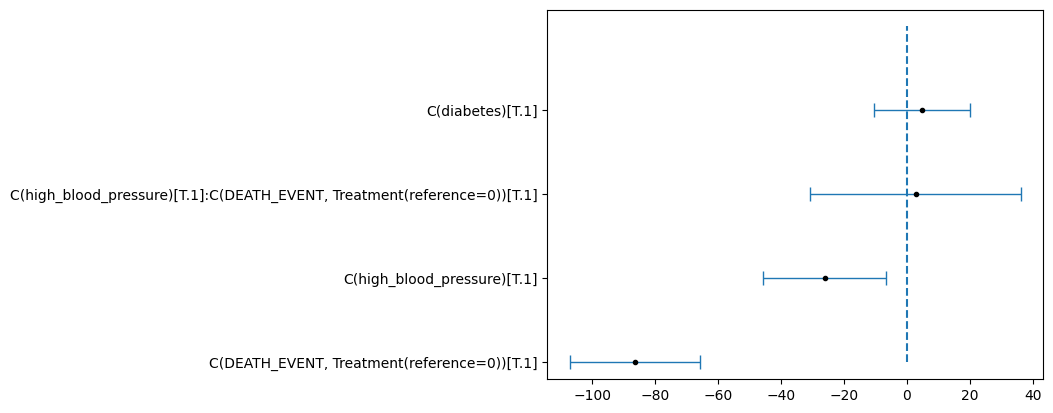

In [1092]:
#fancy plotting

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2);

/var/folders/lx/78bdvyf1797_dxpw5r160s9c0000gn/T/ipykernel_2610/4165489063.py:10: RuntimeWarning: divide by zero encountered in log
  axs[1].plot(odds, np.log(odds))
/var/folders/lx/78bdvyf1797_dxpw5r160s9c0000gn/T/ipykernel_2610/4165489063.py:15: RuntimeWarning: divide by zero encountered in log
  axs[2].plot(p, np.log(odds))


Text(0, 0.5, 'log odds')

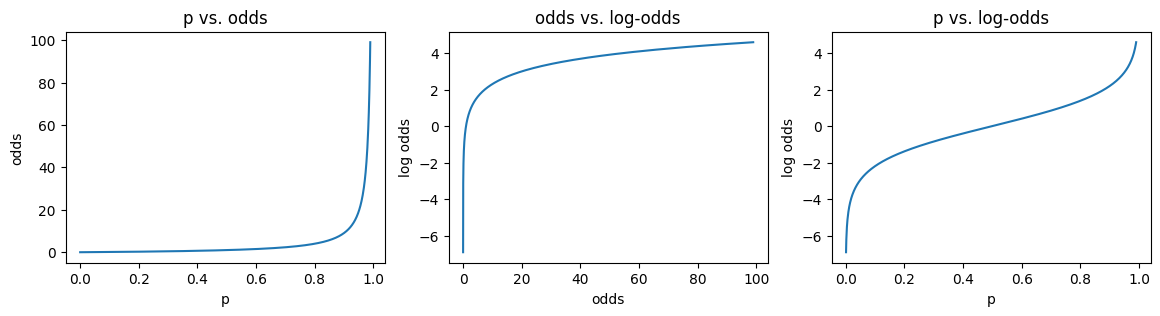

In [1093]:
fig, axs = plt.subplots(1, 3, figsize=(14,3))
p = np.linspace(0, 0.99, 1000)
odds = p/(1-p)
axs[0].set_title("p vs. odds")
axs[0].plot(p, odds)
axs[0].set_xlabel("p")
axs[0].set_ylabel("odds")

axs[1].set_title("odds vs. log-odds")
axs[1].plot(odds, np.log(odds))
axs[1].set_xlabel("odds")
axs[1].set_ylabel("log odds")

axs[2].set_title("p vs. log-odds")
axs[2].plot(p, np.log(odds))
axs[2].set_xlabel("p")
axs[2].set_ylabel("log odds")

In [1094]:
def p_to_log_odds(p):
    return np.log(p/(1-p))
def log_odds_to_p(odds):
    return np.exp(odds) / (1+ np.exp(odds))

In [1095]:
p_to_log_odds(0.1)

-2.197224577336219

In [1096]:
log_odds_to_p(-2.197224577336219)

0.10000000000000003

In [1097]:
odds = p_to_log_odds(0.1)
log_odds_to_p(odds + 0.66)

0.17693910183506342

In [1098]:
odds = p_to_log_odds(0.9)
log_odds_to_p(odds + 0.66)

0.9456909311361745

In [1099]:
"""Your code here"""

mod = smf.logit(formula='DEATH_EVENT ~  serum_creatinine', data=df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.580689
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            DEATH_EVENT   No. Observations:                  299
Model:                          Logit   Df Residuals:                      297
Method:                           MLE   Df Model:                            1
Date:                Fri, 10 Jan 2025   Pseudo R-squ.:                 0.07485
Time:                        19:10:14   Log-Likelihood:                -173.63
converged:                       True   LL-Null:                       -187.67
Covariance Type:            nonrobust   LLR p-value:                 1.154e-07
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.7429      0.131     -5.683      0.000      -0.999      -0.487
serum_creat

In [1100]:
import scipy.stats as stats
stats.pearsonr(df["age"].values, df["serum_creatinine"])

PearsonRResult(statistic=0.15918713328355014, pvalue=0.005803432941203682)

In [1101]:
"""Your code here"""

mod = smf.logit(formula='DEATH_EVENT ~  serum_creatinine + age', data=df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.558734
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            DEATH_EVENT   No. Observations:                  299
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            2
Date:                Fri, 10 Jan 2025   Pseudo R-squ.:                  0.1098
Time:                        19:10:14   Log-Likelihood:                -167.06
converged:                       True   LL-Null:                       -187.67
Covariance Type:            nonrobust   LLR p-value:                 1.117e-09
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.7976      0.136     -5.880      0.000      -1.063      -0.532
serum_creat

In [1102]:
# reload the data to undo the std transforms
data_folder = './ADA_personal/data/'
df = pd.read_csv(data_folder + 'heart_failure_clinical_records_dataset.csv')

In [1103]:
"""Your code here"""

mod = smf.ols(formula='time ~  high_blood_pressure + diabetes + DEATH_EVENT', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     42.69
Date:                Fri, 10 Jan 2025   Prob (F-statistic):           6.12e-23
Time:                        19:10:15   Log-Likelihood:                -1671.0
No. Observations:                 299   AIC:                             3350.
Df Residuals:                     295   BIC:                             3365.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             164.5089    

In [1104]:
"""Your code here"""
df["logtime"] = np.log(df["time"])
mod = smf.ols(formula='logtime ~  high_blood_pressure + diabetes + DEATH_EVENT', data=df)
res = mod.fit()
mod = smf.ols(formula='logtime ~  high_blood_pressure + diabetes + DEATH_EVENT', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                logtime   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     55.05
Date:                Fri, 10 Jan 2025   Prob (F-statistic):           2.75e-28
Time:                        19:10:15   Log-Likelihood:                -325.52
No. Observations:                 299   AIC:                             659.0
Df Residuals:                     295   BIC:                             673.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               4.9891    

In [1105]:
lalonde_data = pd.read_csv(data_folder + 'lalonde.csv')

In [1106]:
treated = lalonde_data.loc[lalonde_data['treat'] == 1] #People that attained the programme
control = lalonde_data.loc[lalonde_data['treat'] == 0] #People that didn't attain the programme

In [1107]:
treated.re78.describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [1108]:
control.re78.describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

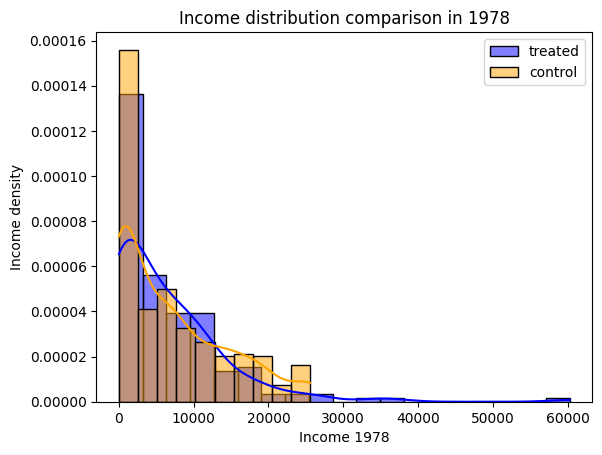

In [1109]:
ax = sns.histplot(treated['re78'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(control['re78'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Income distribution comparison in 1978',xlabel='Income 1978', ylabel='Income density')
plt.legend()
plt.show()

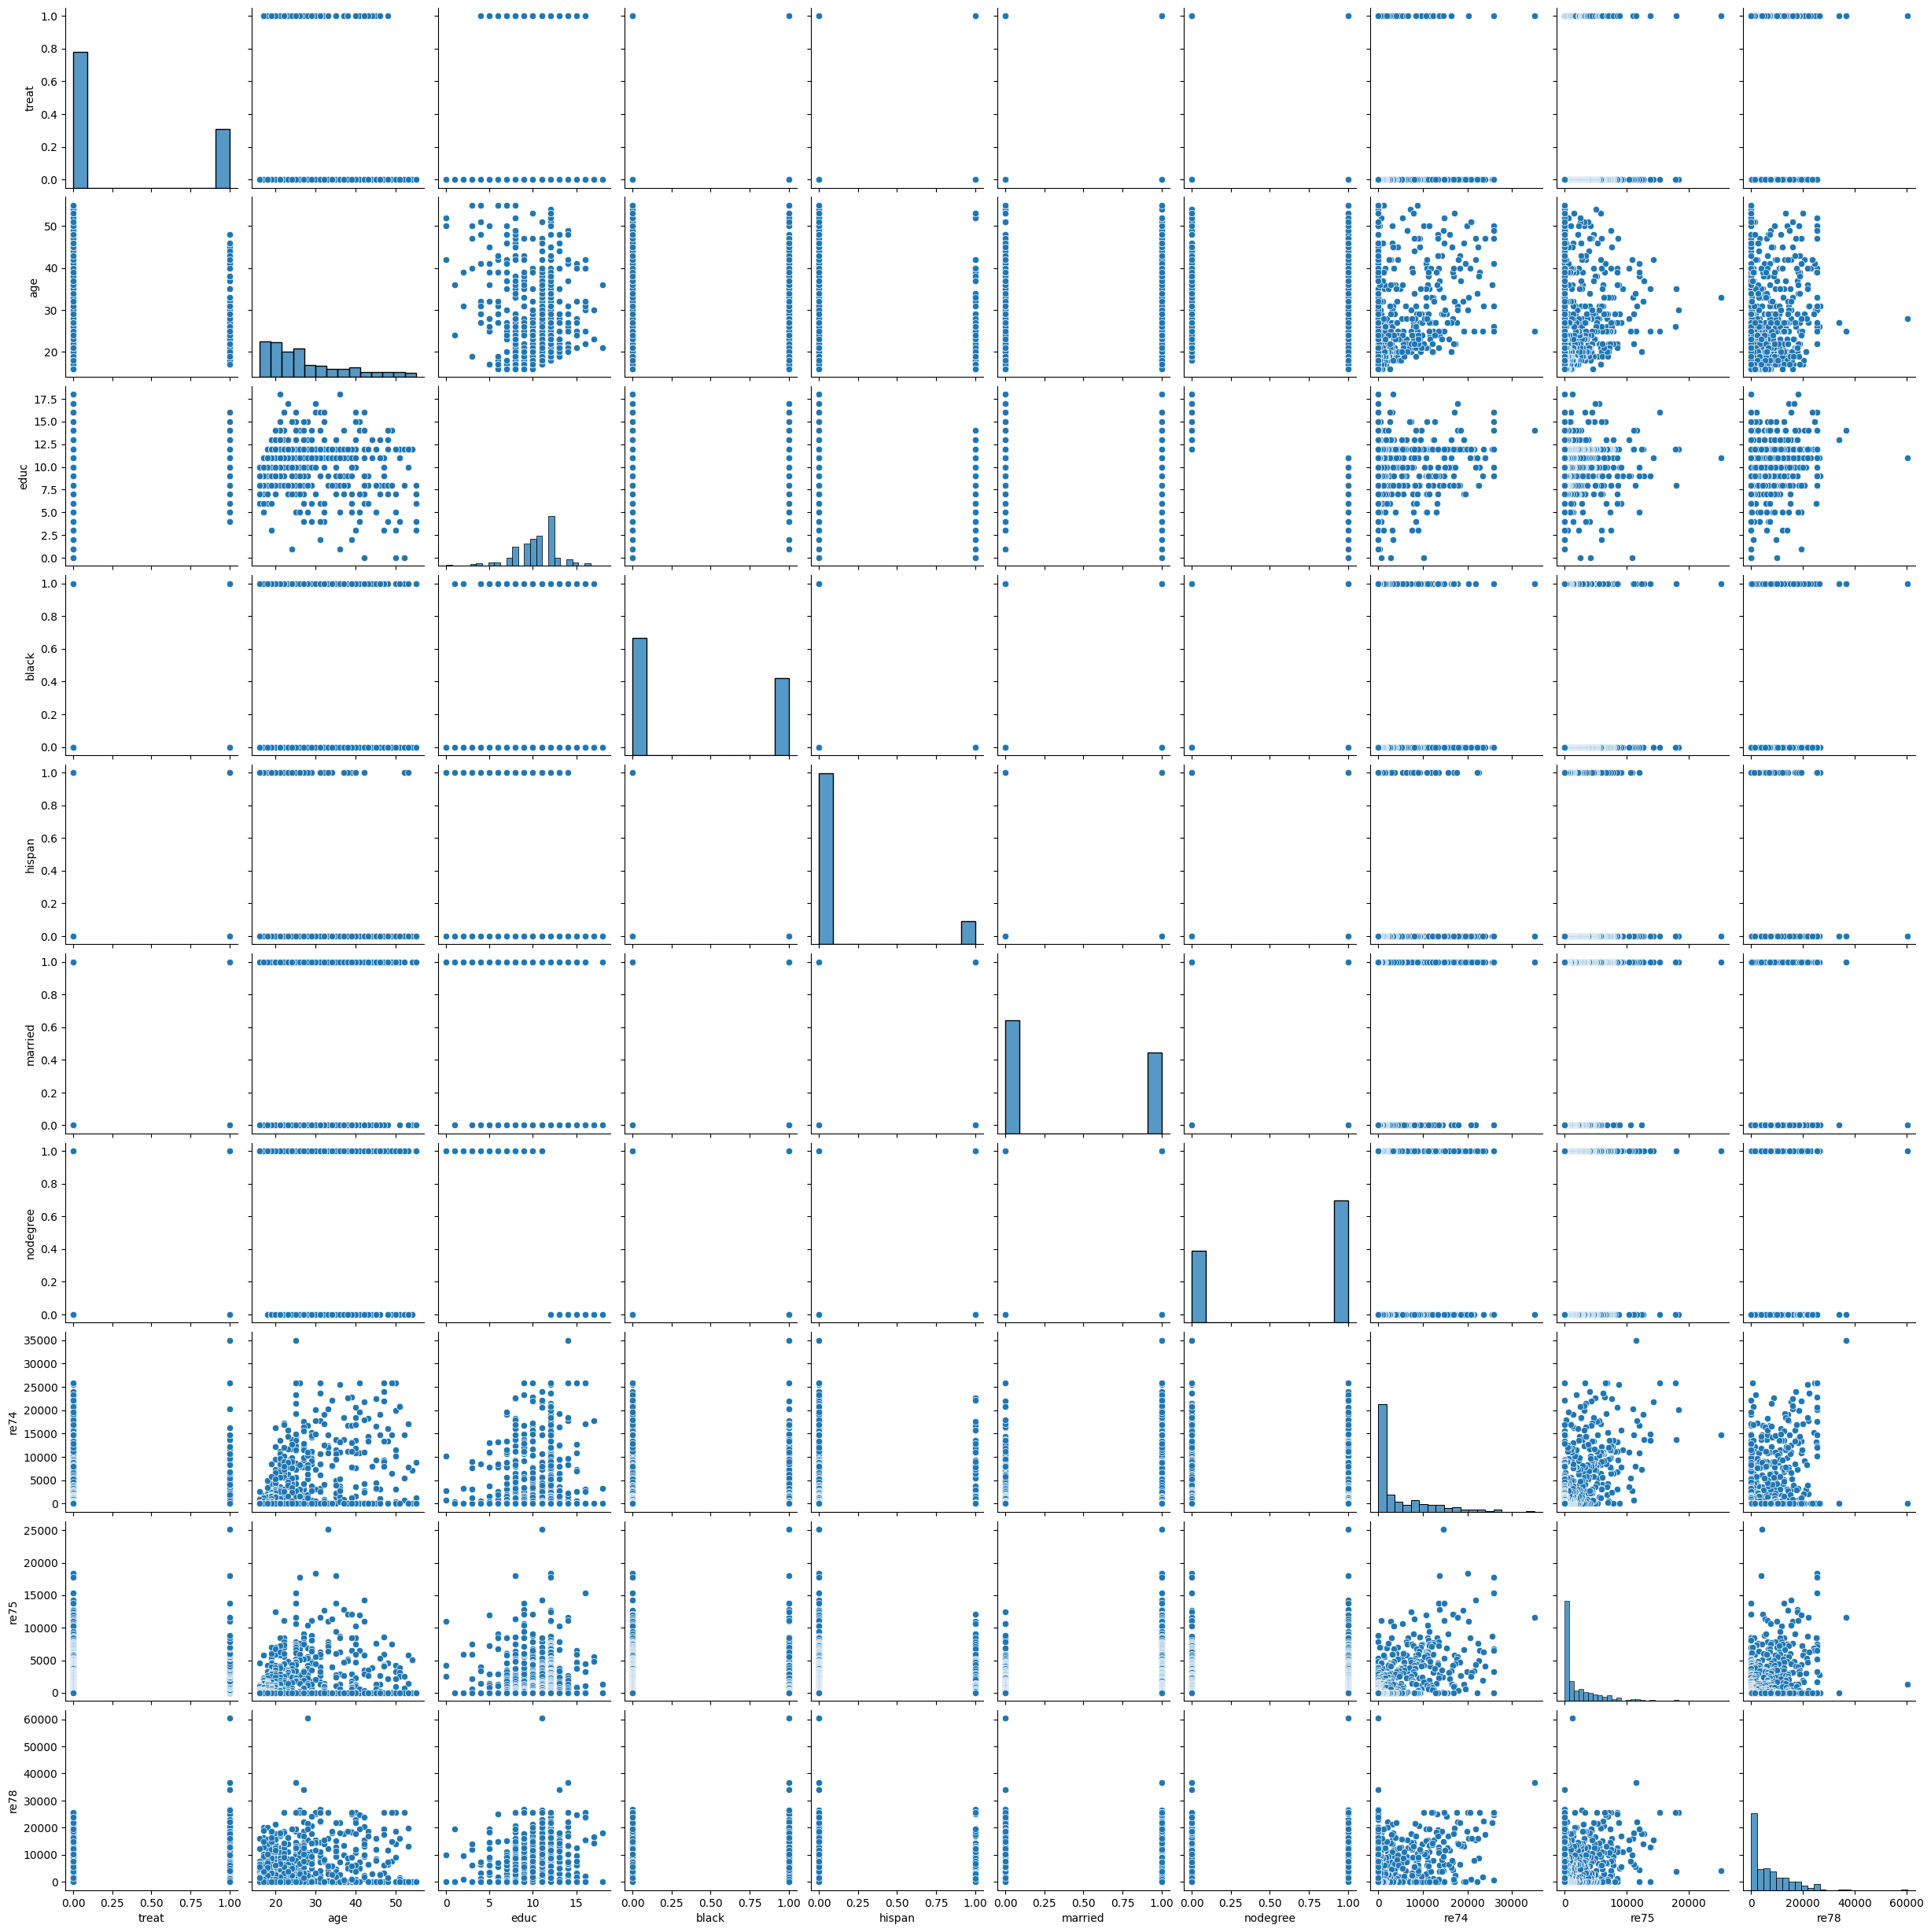

In [1110]:
sns.pairplot(lalonde_data)

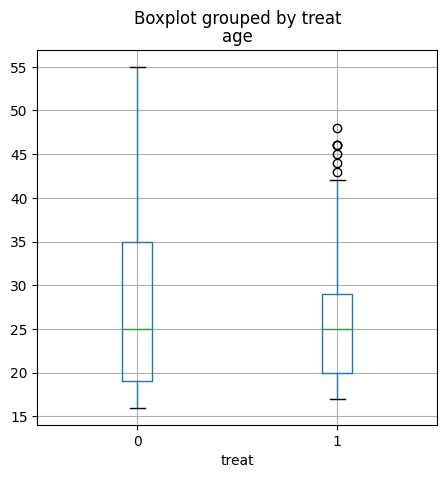

In [1111]:
# Age -- quite different, the members of the treated tend
# to be younger than the ones in the control group

lalonde_data.boxplot(by='treat', column='age', figsize = [5, 5], grid=True)
plt.show()


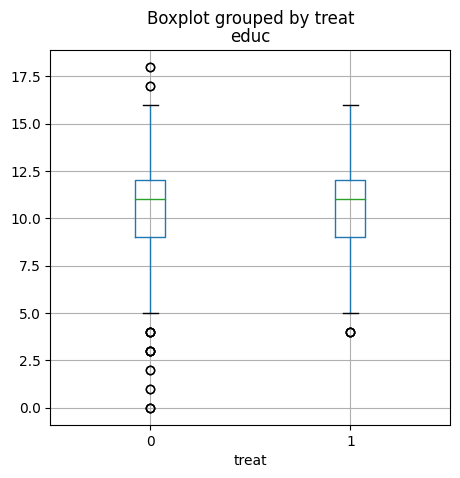

In [1112]:
# education

lalonde_data.boxplot(by='treat', column='educ', figsize = [5, 5], grid=True)
plt.show()

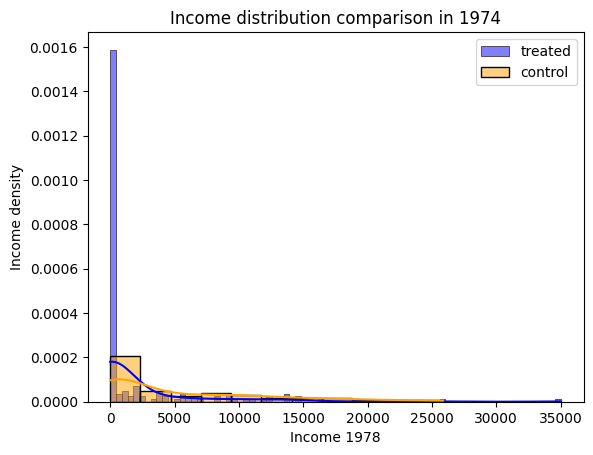

In [1113]:
# income in the previous year

ax = sns.histplot(treated['re74'], stat='density', kde=True, color='blue', label='treated');
ax = sns.histplot(control['re74'], stat='density', kde=True, color='orange', label='control')
ax.set(title='Income distribution comparison in 1974',xlabel='Income 1978', ylabel='Income density')
plt.legend()
plt.show()

# As we can observe from this plot, the number of treated 
# members that were unemployed before the training program is
# quite high. So this might give us an intuition of how much the
# program helped people to find a job, independently of the income 
# that they got eventually. 

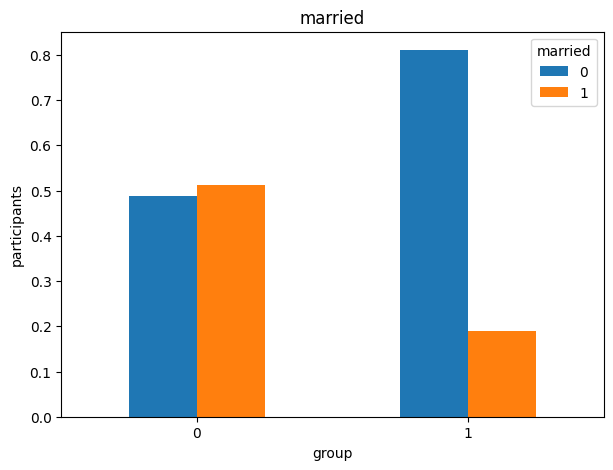

In [1114]:
# marriage

group = lalonde_data.groupby(['treat', 'married'])['married'].count()
group = group.unstack()
group = group.div(group.sum(axis=1), axis=0)
pl = group.plot(kind='bar', figsize=[7,5], rot=0)
pl.set_title('married')
pl.set_ylabel('participants')
pl.set_xlabel('group')
plt.show()

# The percentage of unmarried people between 
# the treated group is much higher than the married ones whereas
# in the control group, the two categories are balanced. This might
# be an indication of what type of people are included in 
# the program.

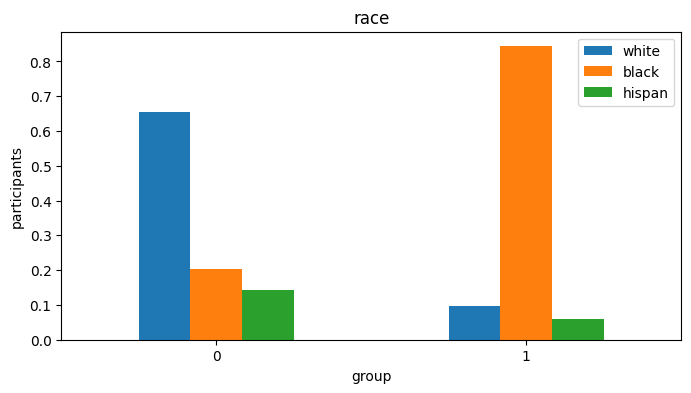

In [1115]:
# race

lalonde_data['white'] = (~(lalonde_data['black'].astype(bool) \
                    | lalonde_data['hispan'].astype(bool))).astype(bool)

lalonde_data_group = lalonde_data.groupby(lalonde_data.treat)[['white', 'black', 'hispan']].sum()
lalonde_data_group = lalonde_data_group.div(lalonde_data_group.sum(axis=1), axis=0)
pl = lalonde_data_group.plot(kind='bar', figsize=[8,4], rot=0)
pl.set_title('race')
pl.set_ylabel('participants')
pl.set_xlabel('group')
plt.show()

# white outnumber the other races in the control group, and on the 
# other hand, in the treated group the proportion of black is almost 
# the only one

In [1116]:
# let's standardize the continuous features
lalonde_data['age'] = (lalonde_data['age'] - lalonde_data['age'].mean())/lalonde_data['age'].std()
lalonde_data['educ'] = (lalonde_data['educ'] - lalonde_data['educ'].mean())/lalonde_data['educ'].std()
lalonde_data['re74'] = (lalonde_data['re74'] - lalonde_data['re74'].mean())/lalonde_data['re74'].std()
lalonde_data['re75'] = (lalonde_data['re75'] - lalonde_data['re75'].mean())/lalonde_data['re75'].std()

mod = smf.logit(formula='treat ~  age + educ + C(black) + C(hispan)  + C(married) + C(nodegree) + \
        +re74 + re75', data=lalonde_data)

res = mod.fit()

# Extract the estimated propensity scores
lalonde_data['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Fri, 10 Jan 2025   Pseudo R-squ.:                  0.3508
Time:                        19:10:24   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.8509      0.350     -8.147      0.000      -3.537      -2.165
C(black)[T.

In [1117]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [1118]:
# Separate the treatment and control groups
treatment_df = lalonde_data[lalonde_data['treat'] == 1]
control_df = lalonde_data[lalonde_data['treat'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [1119]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

In [1120]:
balanced_df_1 = lalonde_data.iloc[matched]

In [1121]:
treatment_df = lalonde_data[lalonde_data['treat'] == 1]
control_df = lalonde_data[lalonde_data['treat'] == 0]


G = nx.Graph()

for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Adds an edge only if the individuals have the same race
        if (control_row['black'] == treatment_row['black'])\
            and (control_row['hispan'] == treatment_row['hispan']):
            similarity = get_similarity(control_row['Propensity_score'],
                                        treatment_row['Propensity_score'])

            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

matching = nx.max_weight_matching(G)

In [1122]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

In [1123]:
balanced_df_all = lalonde_data.iloc[matched]

In [1124]:
treated = balanced_df_all.loc[balanced_df_all['treat'] == 1] #People that attained the program
control = balanced_df_all.loc[balanced_df_all['treat'] == 0] #People that didn't attain the program

In [1125]:
treated.re78.describe()

count      116.000000
mean      6375.738003
std       6670.986821
min          0.000000
25%        758.102600
50%       4648.736000
75%      10160.440000
max      36646.950000
Name: re78, dtype: float64

In [1126]:
control.re78.describe()

count      116.000000
mean      5095.456025
std       6047.014862
min          0.000000
25%          0.000000
50%       2256.488500
75%       8942.092750
max      20243.380000
Name: re78, dtype: float64

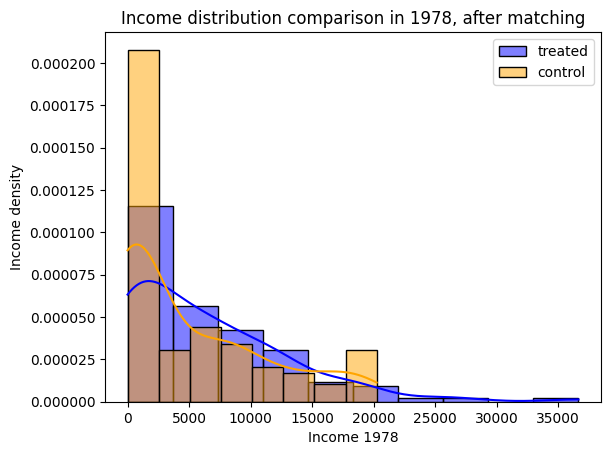

In [1127]:
ax = sns.histplot(treated['re78'], kde=True, stat='density', color='blue', label='treated');
ax = sns.histplot(control['re78'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Income distribution comparison in 1978, after matching',xlabel='Income 1978', ylabel='Income density')
plt.legend()
plt.show()

# Final conclusion: after the propensity score matching, the results drastically change and support the 
# positive effect of the training program.

In [1128]:
data = pd.read_csv('ADA_personal/data/Advertising.csv', index_col=0)
data.head()

TV  radio  newspaper  sales
1  230.1   37.8       69.2   22.1
2   44.5   39.3       45.1   10.4
3   17.2   45.9       69.3    9.3
4  151.5   41.3       58.5   18.5
5  180.8   10.8       58.4   12.9

In [1129]:
data.shape

(200, 4)

<AxesSubplot: xlabel='newspaper', ylabel='sales'>

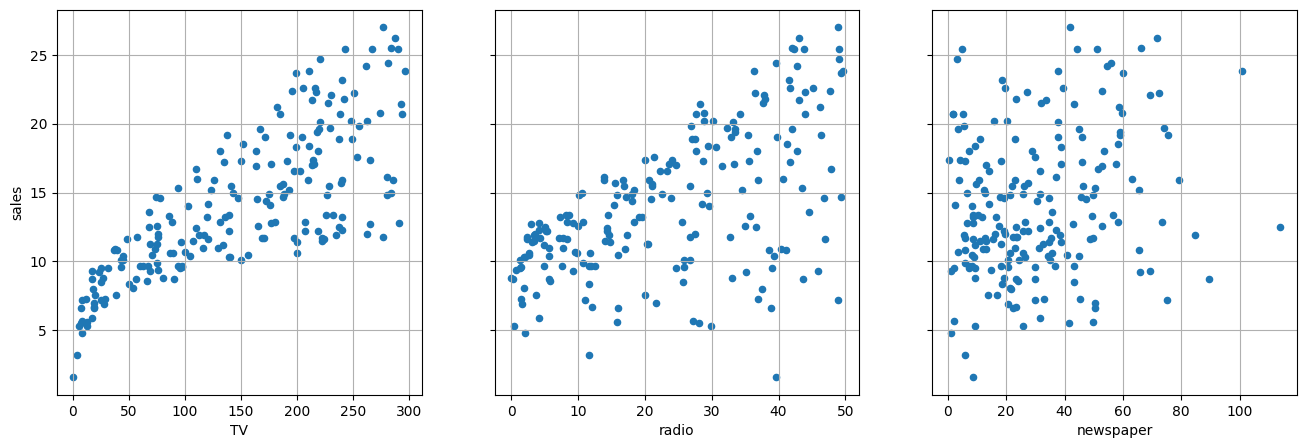

In [1130]:
fig, axs = plt.subplots(1, 3, sharey=True)
data.plot(kind='scatter', x='TV', y='sales', ax=axs[0], figsize=(16, 5), grid=True)
data.plot(kind='scatter', x='radio', y='sales', ax=axs[1], grid=True)
data.plot(kind='scatter', x='newspaper', y='sales', ax=axs[2], grid=True)

In [1131]:
feature_cols = ['TV', 'radio', 'newspaper']
X = data[feature_cols]
y = data.sales

X.describe()

TV       radio   newspaper
count  200.000000  200.000000  200.000000
mean   147.042500   23.264000   30.554000
std     85.854236   14.846809   21.778621
min      0.700000    0.000000    0.300000
25%     74.375000    9.975000   12.750000
50%    149.750000   22.900000   25.750000
75%    218.825000   36.525000   45.100000
max    296.400000   49.600000  114.000000

In [1132]:
lin_reg = LinearRegression()  # create the model
lin_reg.fit(X, y)  # train it

LinearRegression()

In [1133]:
for f in range(len(feature_cols)):
    print("{0} * {1} + ".format(lin_reg.coef_[f], feature_cols[f]))
print(lin_reg.intercept_)

0.04576464545539764 * TV + 
0.18853001691820453 * radio + 
-0.0010374930424762346 * newspaper + 
2.9388893694594014


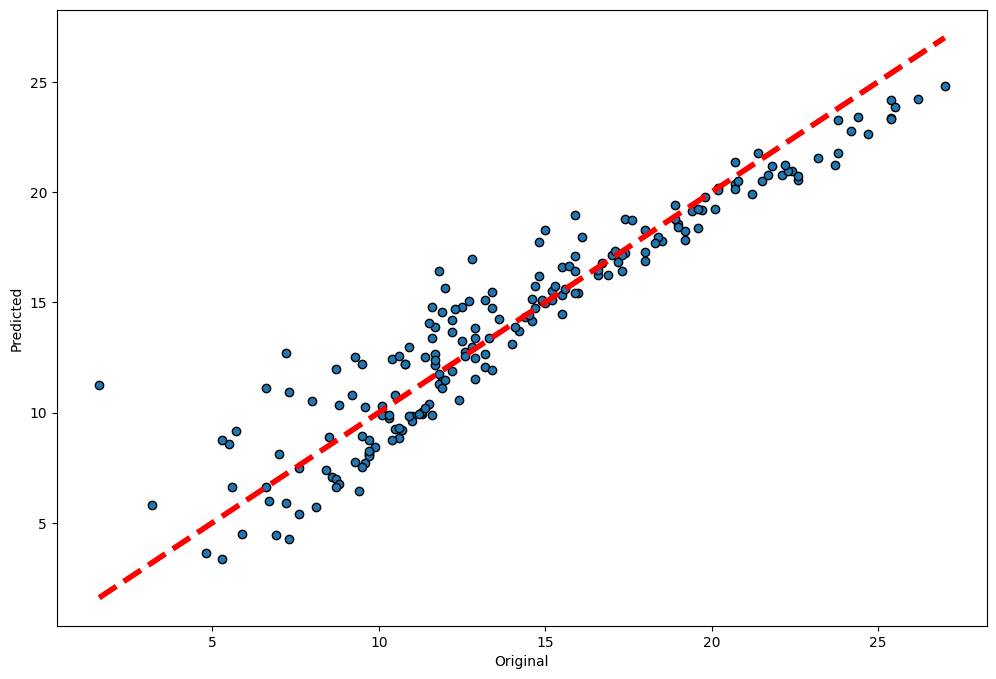

In [1134]:
lr = LinearRegression()

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, X, y, cv=5)

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([min(y), max(y)], [min(y), max(y)], 'r--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

In [1135]:
mean_squared_error(y, predicted)

3.0729465971002083

In [1136]:
X = X[:5]
y = y[:5]

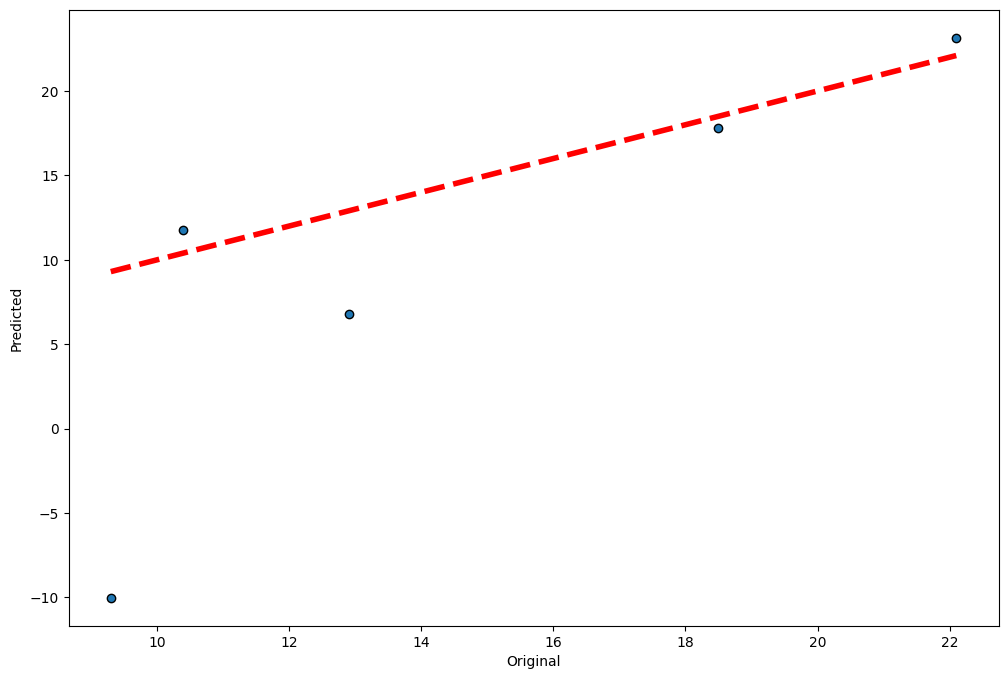

In [1137]:
lr = LinearRegression()

predicted = cross_val_predict(lr, X, y, cv=5)

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([min(y), max(y)], [min(y), max(y)], 'r--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

In [1138]:
mean_squared_error(y, predicted)

82.7741926240416

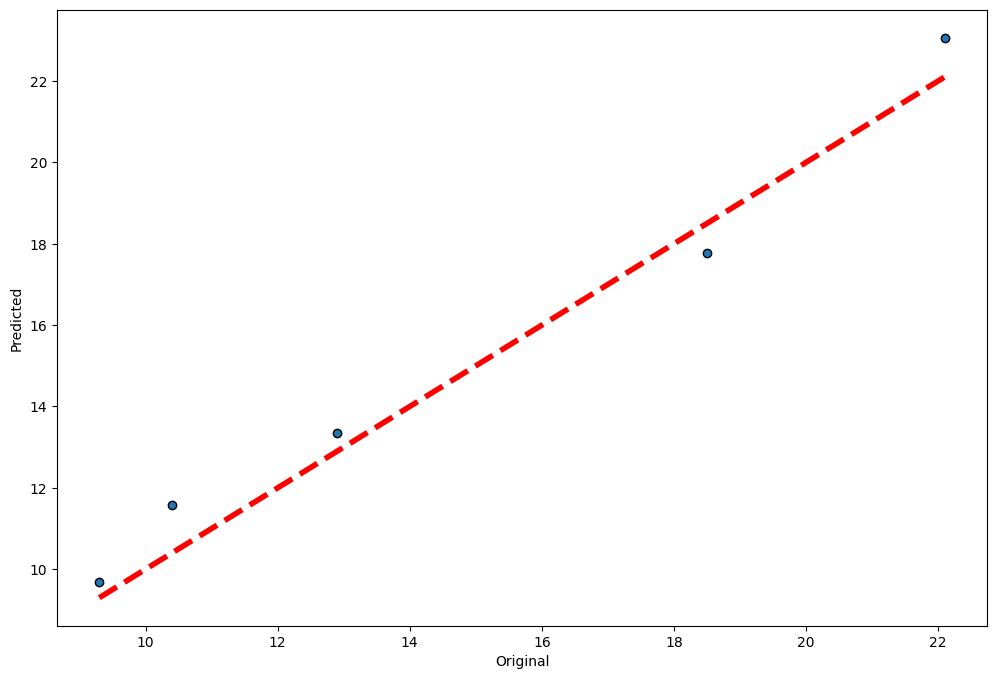

In [1139]:
ridge = Ridge(alpha=6)

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted_r = cross_val_predict(ridge, X, y, cv=5)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, predicted_r, edgecolors=(0, 0, 0))
ax.plot([min(y), max(y)], [min(y), max(y)], 'r--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

In [1140]:
mean_squared_error(y, predicted_r)

0.644246258057233

In [1141]:
titanic = pd.read_excel('ADA_personal/data/titanic.xls')
titanic.head(5)

survived                                             name     sex      age  \
0         1                    Allen, Miss. Elisabeth Walton  female  29.0000   
1         1                   Allison, Master. Hudson Trevor    male   0.9167   
2         0                     Allison, Miss. Helen Loraine  female   2.0000   
3         0             Allison, Mr. Hudson Joshua Creighton    male  30.0000   
4         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female  25.0000   

   sibsp  parch  ticket      fare    cabin embarked  
0      0      0   24160  211.3375       B5        S  
1      1      2  113781  151.5500  C22 C26        S  
2      1      2  113781  151.5500  C22 C26        S  
3      1      2  113781  151.5500  C22 C26        S  
4      1      2  113781  151.5500  C22 C26        S

In [1142]:
dead = titanic[titanic['survived']==0]
survived = titanic[titanic['survived']==1]

print("Survived {0}, Dead {1}".format(len(survived), len(dead)))
print("Survived {:.2%}".format(len(survived)/len(titanic)))

Survived 500, Dead 809
Survived 38.20%


In [1143]:
titanic_features = ['sex', 'age', 'sibsp', 'parch', 'fare']

In [1144]:
# The features vector
X = pd.get_dummies(titanic[titanic_features])
X.head()

age  sibsp  parch      fare  sex_female  sex_male
0  29.0000      0      0  211.3375        True     False
1   0.9167      1      2  151.5500       False      True
2   2.0000      1      2  151.5500        True     False
3  30.0000      1      2  151.5500       False      True
4  25.0000      1      2  151.5500        True     False

In [1145]:
len(X[X.isna().any(axis=1)])

264

In [1146]:
X = X.fillna(X.mean())

len(X[X.isna().any(axis=1)])

0

In [1147]:
y = titanic['survived']

In [1148]:
logistic = LogisticRegression(solver='lbfgs')

In [1149]:
precision = cross_val_score(logistic, X, y, cv=10, scoring="precision")
recall = cross_val_score(logistic, X, y, cv=10, scoring="recall")

# Precision: avoid false positives
print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
# Recall: avoid false negatives
print("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))

Precision: 0.72 (+/- 0.13)
Recall: 0.68 (+/- 0.16)


In [1150]:
# Predict the probabilities with a cross validationn
y_pred = cross_val_predict(logistic, X, y, cv=10, method="predict_proba")
# Compute the False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(y, y_pred[:, 1])
# Compute the area under the fpt-tpf curve
auc_score = auc(fpr, tpr)

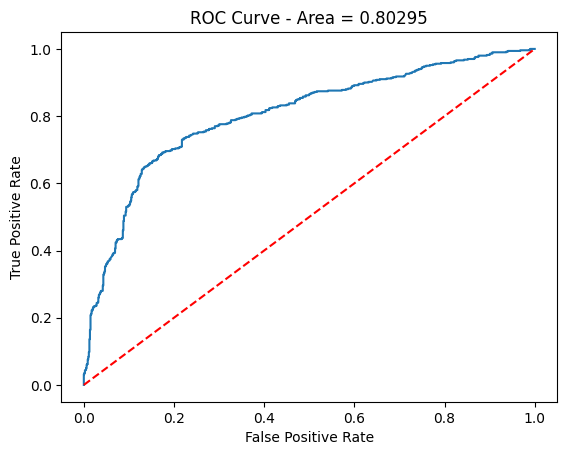

In [1151]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Area = {:.5f}".format(auc_score));

In [1152]:
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(X.values, y)

LogisticRegression()

In [1153]:
X.columns

Index(['age', 'sibsp', 'parch', 'fare', 'sex_female', 'sex_male'], dtype='object')

In [1154]:
test = [25, 0, 0, 100, 0, 1]
"YES" if logistic.predict([test])[0] > 0 else "NO"

'NO'

In [1155]:
logistic.predict_proba([test])

array([[0.5528599, 0.4471401]])

In [1156]:
test = [35, 0, 0, 100, 1, 0]
"YES" if logistic.predict([test])[0] > 0 else "NO"

print(logistic.predict_proba([test])[0])

[0.11464109 0.88535891]


Text(0.5, 1.0, 'Circles')

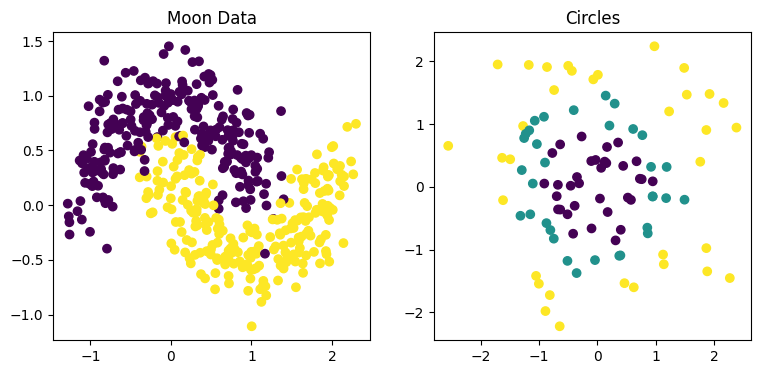

In [1157]:
from sklearn.datasets import make_moons, make_gaussian_quantiles
from sklearn.model_selection import train_test_split

X_moons, y_moons = make_moons(500, noise=0.2, random_state=0)
X_circles, y_circles = make_gaussian_quantiles(n_samples=100, random_state=0)


fig, axs = plt.subplots(1, 2, figsize=(9,4))

axs[0].scatter(X_moons[:,0], X_moons[:,1], c=y_moons)
axs[0].set_title('Moon Data')

axs[1].scatter(X_circles[:,0], X_circles[:,1], c=y_circles)
axs[1].set_title('Circles')

In [1158]:
# Plotting helper 
# Source: https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
from matplotlib.colors import ListedColormap

def plot_prediction(model, X, y, ax, K):
    # step size in the mesh
    h = .02
    # Create color maps
    cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
    cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title("K = {}".format(K))

In [1159]:
# K = 1
clf_moons_1 = KNeighborsClassifier(1)
clf_moons_1.fit(X_moons, y_moons)
clf_circles_1 = KNeighborsClassifier(1)
clf_circles_1.fit(X_circles, y_circles)

# K = 15
clf_moons_15 = KNeighborsClassifier(15)
clf_moons_15.fit(X_moons, y_moons)
clf_circles_15 = KNeighborsClassifier(15)
clf_circles_15.fit(X_circles, y_circles)

KNeighborsClassifier(n_neighbors=15)

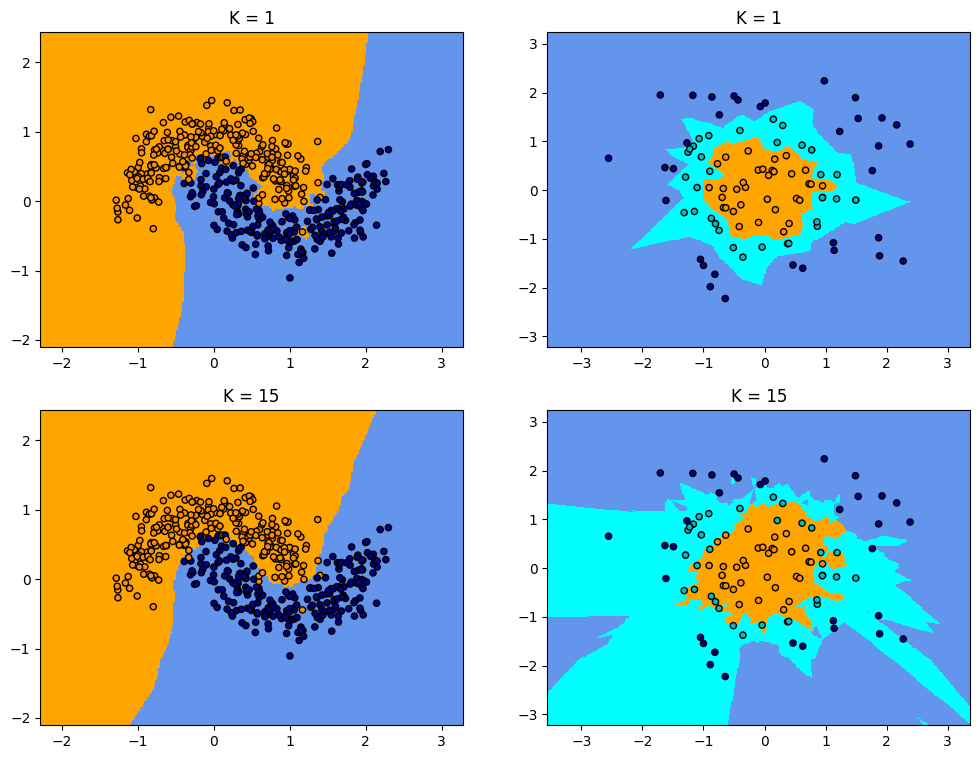

In [1160]:
fig, axs = plt.subplots(2, 2, figsize=(12,9))

plot_prediction(clf_moons_1, X_moons, y_moons, axs[0][0], 1)
plot_prediction(clf_circles_1, X_circles, y_circles, axs[0][1], 1)

plot_prediction(clf_moons_15, X_moons, y_moons, axs[1][0], 15)
plot_prediction(clf_circles_15, X_circles, y_circles, axs[1][1], 15)

In [1161]:
columns = ['animal_type', 'intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake', \
          'age_upon_intake_(years)', 'time_in_shelter_days', 'sex_upon_outcome', 'age_upon_outcome_(years)', \
          'outcome_type']
original_data = pd.read_csv(data_folder+'aac_intakes_outcomes.csv', usecols=columns)

In [1162]:
print('The length of the data with all rows is : {}'.format(len(original_data)))
original_data.dropna(inplace=True)
print('The length of the data without the rows with nan value is: {}'.format(len(original_data)))

The length of the data with all rows is : 79672
The length of the data without the rows with nan value is: 79661


In [1163]:
data_features = original_data.copy()
data_features['adopted'] = data_features.outcome_type.apply(lambda r: 1 if r=='Adoption' else 0)
data_features.drop("outcome_type", axis = 1, inplace=True)
data_features.head()

sex_upon_outcome  age_upon_outcome_(years) animal_type intake_condition  \
0    Neutered Male                      10.0         Dog           Normal   
1    Neutered Male                       7.0         Dog           Normal   
2    Neutered Male                       6.0         Dog           Normal   
3    Neutered Male                      10.0         Dog           Normal   
4    Neutered Male                      16.0         Dog          Injured   

       intake_type sex_upon_intake  age_upon_intake_(years)  intake_year  \
0            Stray   Neutered Male                     10.0         2017   
1    Public Assist   Neutered Male                      7.0         2014   
2    Public Assist   Neutered Male                      6.0         2014   
3  Owner Surrender   Neutered Male                     10.0         2014   
4    Public Assist   Neutered Male                     16.0         2013   

   intake_number  time_in_shelter_days  adopted  
0            1.0              0.588194        0  
1            2.0              1.259722        0  
2            3.0              1.113889        0  
3            1.0              4.970139        0  
4            1.0              0.119444        0

In [1164]:
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [1165]:
[train, test] = split_set(data_features)

In [1166]:
categorical_columns = ['sex_upon_outcome', 'animal_type', 'intake_condition',
                       'intake_type', 'sex_upon_intake']
train_categorical = pd.get_dummies(train, columns=categorical_columns)
train_categorical.columns

Index(['age_upon_outcome_(years)', 'age_upon_intake_(years)', 'intake_year',
       'intake_number', 'time_in_shelter_days', 'adopted',
       'sex_upon_outcome_Intact Female', 'sex_upon_outcome_Intact Male',
       'sex_upon_outcome_Neutered Male', 'sex_upon_outcome_Spayed Female',
       'sex_upon_outcome_Unknown', 'animal_type_Bird', 'animal_type_Cat',
       'animal_type_Dog', 'animal_type_Other', 'intake_condition_Aged',
       'intake_condition_Feral', 'intake_condition_Injured',
       'intake_condition_Normal', 'intake_condition_Nursing',
       'intake_condition_Other', 'intake_condition_Pregnant',
       'intake_condition_Sick', 'intake_type_Euthanasia Request',
       'intake_type_Owner Surrender', 'intake_type_Public Assist',
       'intake_type_Stray', 'intake_type_Wildlife',
       'sex_upon_intake_Intact Female', 'sex_upon_intake_Intact Male',
       'sex_upon_intake_Neutered Male', 'sex_upon_intake_Spayed Female',
       'sex_upon_intake_Unknown'],
      dtype='object')

In [1167]:
# Make sure we use only the features available in the training set
test_categorical = pd.get_dummies(test, columns=categorical_columns)[train_categorical.columns]

In [1168]:
train_label=train_categorical.adopted
train_features = train_categorical.drop('adopted', axis=1)
print('Length of the train dataset : {}'.format(len(train)))

test_label=test_categorical.adopted
test_features = test_categorical.drop('adopted', axis=1)
print('Length of the test dataset : {}'.format(len(test)))

Length of the train dataset : 63685
Length of the test dataset : 15976


In [1169]:
means = train_features.mean()
stddevs = train_features.std()

train_features_std = pd.DataFrame()
for c in train_features.columns:
    train_features_std[c] = (train_features[c]-means[c])/stddevs[c]

# Use the mean and stddev of the training set
test_features_std = pd.DataFrame()
for c in test_features.columns:
    test_features_std[c] = (test_features[c]-means[c])/stddevs[c]

train_features_std.head()

age_upon_outcome_(years)  age_upon_intake_(years)  intake_year  \
0                  2.716904                 2.735632     1.197132   
1                  1.679814                 1.696008    -1.103577   
2                  1.334117                 1.349467    -1.103577   
3                  2.716904                 2.735632    -1.103577   
4                  4.791085                 4.814880    -1.870480   

   intake_number  time_in_shelter_days  sex_upon_outcome_Intact Female  \
0      -0.275558             -0.395671                       -0.364251   
1       1.913948             -0.379203                       -0.364251   
2       4.103454             -0.382779                       -0.364251   
3      -0.275558             -0.288212                       -0.364251   
4      -0.275558             -0.407166                       -0.364251   

   sex_upon_outcome_Intact Male  sex_upon_outcome_Neutered Male  \
0                     -0.372826                          1.3507   
1                     -0.372826                          1.3507   
2                     -0.372826                          1.3507   
3                     -0.372826                          1.3507   
4                     -0.372826                          1.3507   

   sex_upon_outcome_Spayed Female  sex_upon_outcome_Unknown  ...  \
0                       -0.688213                 -0.305487  ...   
1                       -0.688213                 -0.305487  ...   
2                       -0.688213                 -0.305487  ...   
3                       -0.688213                 -0.305487  ...   
4                       -0.688213                 -0.305487  ...   

   intake_type_Euthanasia Request  intake_type_Owner Surrender  \
0                       -0.054413                    -0.481199   
1                       -0.054413                    -0.481199   
2                       -0.054413                    -0.481199   
3                       -0.054413                     2.078110   
4                       -0.054413                    -0.481199   

   intake_type_Public Assist  intake_type_Stray  intake_type_Wildlife  \
0                  -0.260118            0.65126             -0.213203   
1                   3.844347           -1.53546             -0.213203   
2                   3.844347           -1.53546             -0.213203   
3                  -0.260118           -1.53546             -0.213203   
4                   3.844347           -1.53546             -0.213203   

   sex_upon_intake_Intact Female  sex_upon_intake_Intact Male  \
0                      -0.651285                    -0.680372   
1                      -0.651285                    -0.680372   
2                      -0.651285                    -0.680372   
3                      -0.651285                    -0.680372   
4                      -0.651285                    -0.680372   

   sex_upon_intake_Neutered Male  sex_upon_intake_Spayed Female  \
0                       2.294165                      -0.404656   
1                       2.294165                      -0.404656   
2                       2.294165                      -0.404656   
3                       2.294165                      -0.404656   
4                       2.294165                      -0.404656   

   sex_upon_intake_Unknown  
0                -0.305487  
1                -0.305487  
2                -0.305487  
3                -0.305487  
4                -0.305487  

[5 rows x 32 columns]

In [1170]:
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)   
                                                                                                                       
    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix


def plot_confusion_matrix(confusion_matrix):
    [[TP, FP],[FN, TN]] = confusion_matrix
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]])
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 
    
    return sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')


def compute_all_score(confusion_matrix, t=0.5):
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

In [1171]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(train_features_std,train_label)

LogisticRegression(max_iter=10000)

In [1172]:
prediction_proba = logistic.predict_proba(test_features_std)

Text(0.5, 1.0, 'Confusion matrix for a 0.5 threshold')

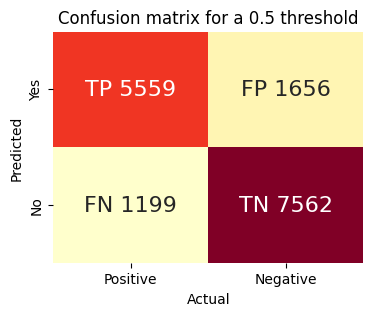

In [1173]:
confusion_matrix_05 = compute_confusion_matrix(test_label, prediction_proba, 0.5 )
plt.figure(figsize = (4,3)) 
ax = plot_confusion_matrix(confusion_matrix_05)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for a 0.5 threshold')

In [1174]:
[t, accuracy, precision_positive, recall_positive, F1_score_positive, \
    precision_negative, recall_negative, F1_score_negative] = compute_all_score(confusion_matrix_05)

print("The accuracy of this model is {0:1.3f}".format(accuracy))
print("For the positive case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_positive, recall_positive, F1_score_positive))
print("For the negative case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_negative, recall_negative, F1_score_negative))

The accuracy of this model is 0.821
For the positive case, the precision is 0.770, the recall is 0.823 and the F1 score is 0.796
For the negative case, the precision is 0.863, the recall is 0.820 and the F1 score is 0.841


In [1175]:
threshold = np.linspace(0, 1, 100)

In [1176]:
columns_score_name = ['Threshold', 'Accuracy', 'Precision P', 'Recall P', 'F1 score P', \
                                              'Precision N', 'Recall N', 'F1 score N']
threshold_score = pd.concat([pd.DataFrame([compute_all_score(compute_confusion_matrix(test_label, prediction_proba, t ),t)]\
                                             , columns=columns_score_name) for t in threshold], ignore_index=True)
threshold_score.set_index('Threshold', inplace=True)

Text(0.5, 1.0, 'Accuracy')

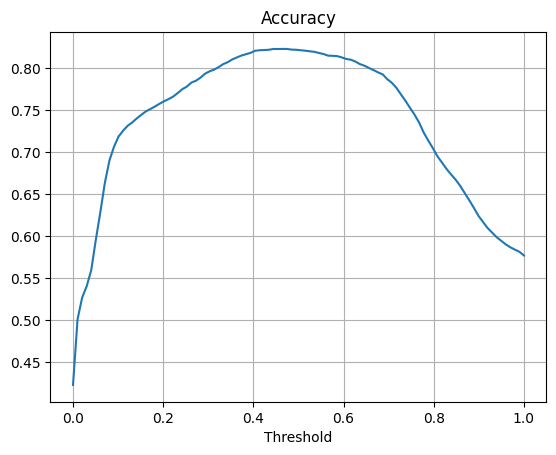

In [1177]:
threshold_score['Accuracy'].plot(grid=True).set_title('Accuracy')

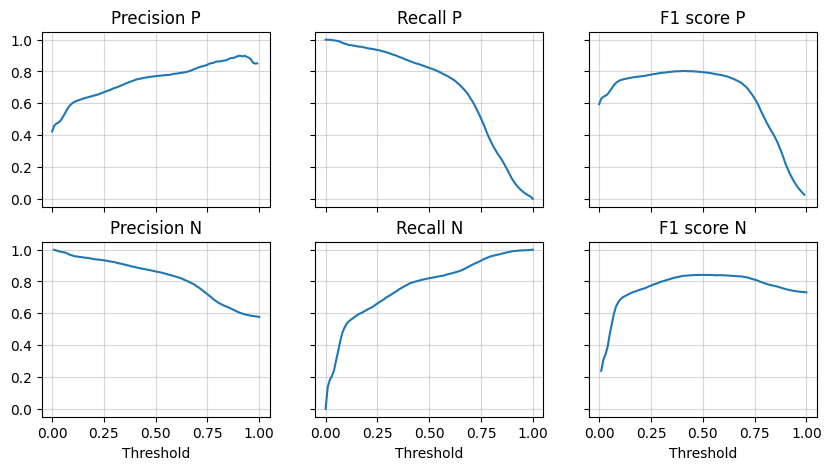

In [1178]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10,5))

col_plot = ['Precision P', 'Recall P', 'F1 score P', 'Precision N', 'Recall N', 'F1 score N']

major_ticks = np.linspace(0,1,5)

for axe, col in zip(axs.flat, col_plot):
    threshold_score[col].plot(ax=axe, grid = True)
    axe.set_title(col)
    axe.set_xticks(major_ticks)    
    axe.grid(which='major', alpha=0.5)

In [1179]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(train_features_std, train_label)

LogisticRegression(max_iter=10000)

In [1180]:
tmp = []
for name, value in zip(train_features_std.columns, logistic.coef_[0]):
    tmp.append({"name": name, "value": value})
    
features_coef = pd.DataFrame(tmp).sort_values("value")
features_coef.head()

name     value
1          age_upon_intake_(years) -1.558941
6     sex_upon_outcome_Intact Male -0.779915
5   sex_upon_outcome_Intact Female -0.692547
26            intake_type_Wildlife -0.588030
31         sex_upon_intake_Unknown -0.486746

<BarContainer object of 32 artists>

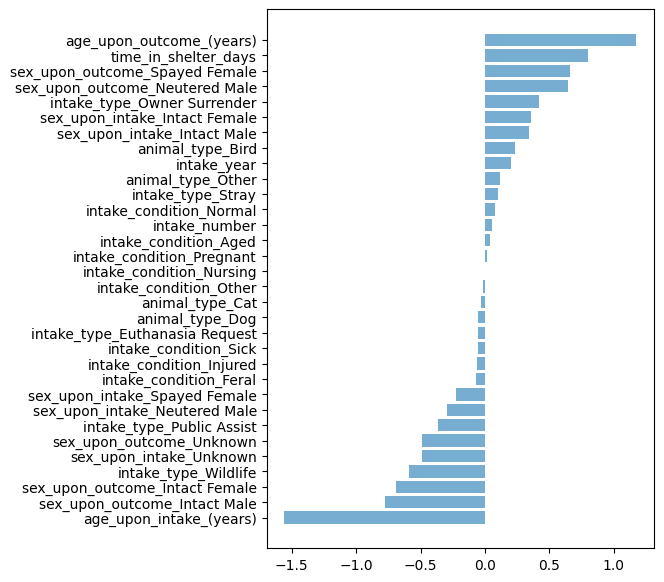

In [1181]:
plt.subplots(figsize=(5,7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)

In [1182]:
random.seed(42)
top_secret_number = random.randint(2, 10)

In [1183]:
total_samples = 100

# This create some artifical clusters with standard dev. = 2
X, _, centers = make_blobs(n_samples=total_samples, 
                           centers=top_secret_number, 
                           cluster_std=2,
                           n_features=2,
                           return_centers=True, 
                           random_state=42)

X[:3]

array([[-8.57321463, -9.90980404],
       [ 6.26691327, -0.48855895],
       [-3.44814639, 10.09940622]])

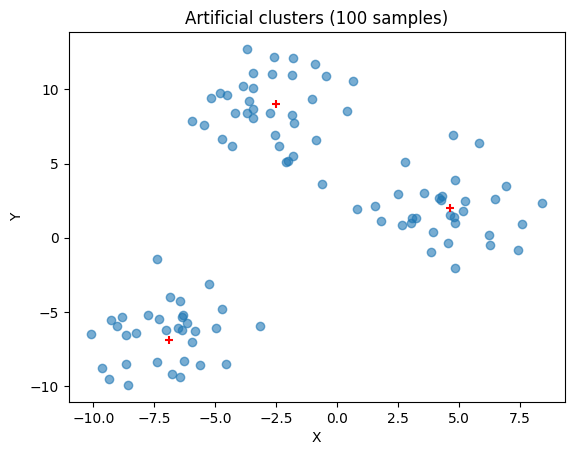

In [1184]:
plt.scatter(X[:,0], X[:,1], alpha=0.6)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Artificial clusters (%s samples)" % total_samples)

for c in centers:
    plt.scatter(c[0], c[1], marker="+", color="red")

/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The 

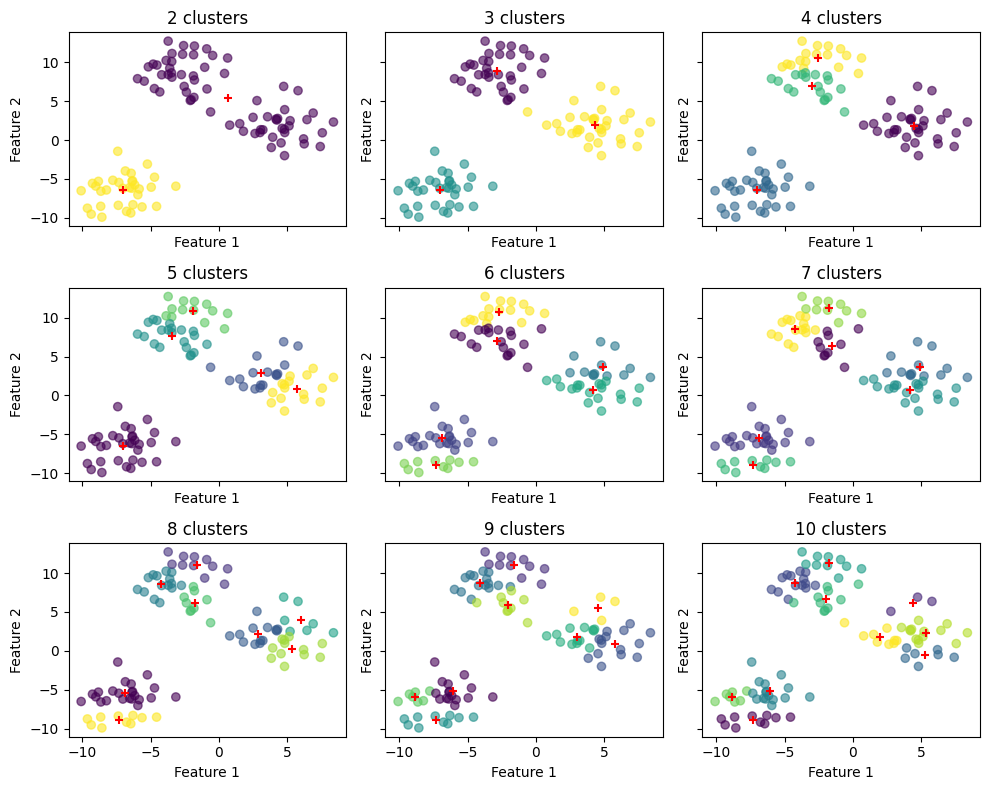

In [1185]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 10

# Compute number of row and columns
COLUMNS = 3
ROWS = math.ceil((MAX_CLUSTERS-MIN_CLUSTERS)/COLUMNS)
fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(10,8), sharey=True, sharex=True)

# Plot the clusters
for n_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    current_column = (n_clusters-MIN_CLUSTERS)%COLUMNS
    current_row = (n_clusters-MIN_CLUSTERS)//COLUMNS
    # Get the axis where to add the plot
    ax = axs[current_row, current_column]
    # Cluster the data with the current number of clusters
    kmean = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    # Plot the data by using the labels as color
    ax.scatter(X[:,0], X[:,1], c=kmean.labels_, alpha=0.6)
    ax.set_title("%s clusters"%n_clusters)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    # Plot the centroids
    for c in kmean.cluster_centers_:
        ax.scatter(c[0], c[1], marker="+", color="red")

plt.tight_layout()

/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The 

Text(0, 0.5, 'Silhouette score')

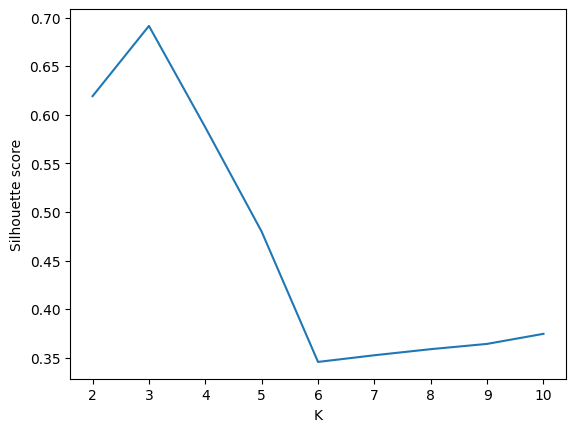

In [1186]:
silhouettes = []

# Try multiple k
for k in range(2, 11):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=10).fit_predict(X)
    # Get the Silhouette score
    score = silhouette_score(X, labels)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")

/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The 

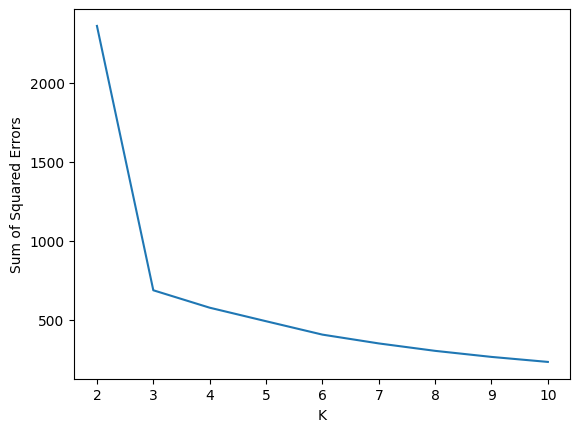

In [1187]:
def plot_sse(features_X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    
plot_sse(X)

/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


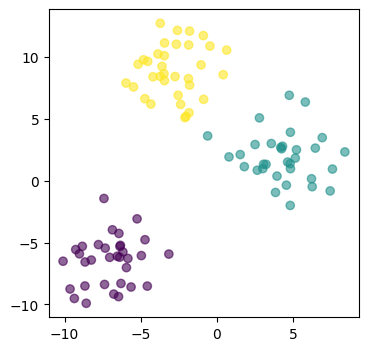

In [1188]:
fig, axs = plt.subplots(1, 1, figsize=(4,4), sharey=True)

# Plot the clusters with K = 3
labels = KMeans(n_clusters=3, random_state=0).fit_predict(X)
axs.scatter(X[:,0], X[:,1], c=labels, alpha=0.6)

In [1189]:
total_samples = 100

# This create some artifical clusters with standard dev. = 3
X10d, _ = make_blobs(n_samples=total_samples, 
                           centers=top_secret_number, 
                           cluster_std=3,
                           n_features=10,
                           random_state=0)

print("The features of the first sample are: %s" % X10d[0])

The features of the first sample are: [ 7.05933272  4.20962197 -2.77357361  6.59147131 -6.64440614  9.47625342
 -3.01996723  7.36384861  1.41157528  1.28459274]


In [1190]:
X_reduced_tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=0).fit_transform(X10d)

print("The features of the first sample are: %s" % X_reduced_tsne[0])

The features of the first sample are: [ 3.2180345 -1.7569892]


In [1191]:
X_reduced_pca = PCA(n_components=2).fit(X10d).transform(X10d)

print("The features of the first sample are: %s" % X_reduced_pca[0])

The features of the first sample are: [-6.17922102  7.01618025]


/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'PCA')

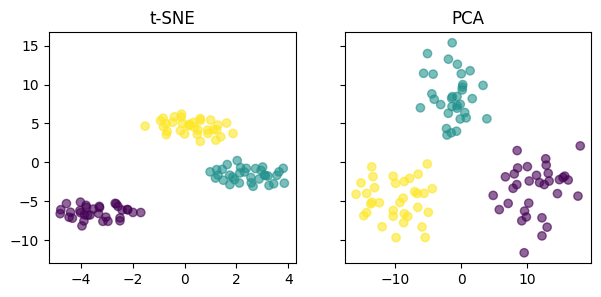

In [1192]:
fig, axs = plt.subplots(1, 2, figsize=(7,3), sharey=True)

# Cluster the data in 3 groups
labels = KMeans(n_clusters=3, random_state=0).fit_predict(X10d)

# Plot the data reduced in 2d space with t-SNE
axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels, alpha=0.6)
axs[0].set_title("t-SNE")

# Plot the data reduced in 2d space with PCA
axs[1].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels, alpha=0.6)
axs[1].set_title("PCA")

Text(0, 0.5, 'Feature 2')

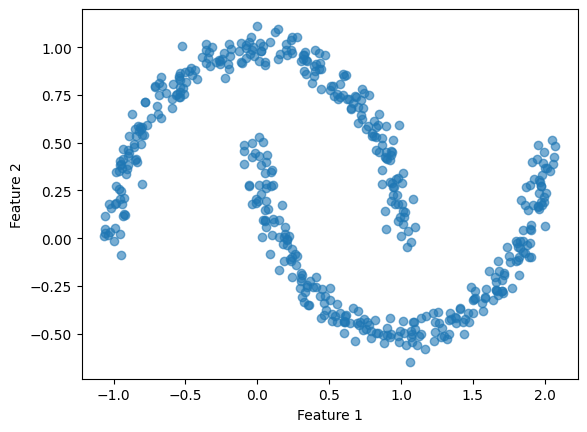

In [1193]:
# Create 500 random points with 2-moons shape
X_moons, _ = make_moons(500, noise=0.05, random_state=0)

plt.scatter(X_moons[:,0], X_moons[:,1], alpha=0.6)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


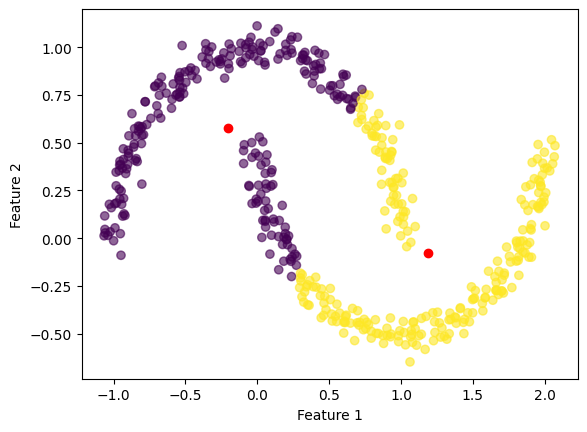

In [1194]:
kmean = KMeans(n_clusters=2, random_state=0).fit(X_moons)
plt.scatter(X_moons[:,0], X_moons[:,1], c=kmean.labels_, alpha=0.6)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Plot the centroids
for c in kmean.cluster_centers_:
    plt.scatter(c[0], c[1], marker="o", color="red")

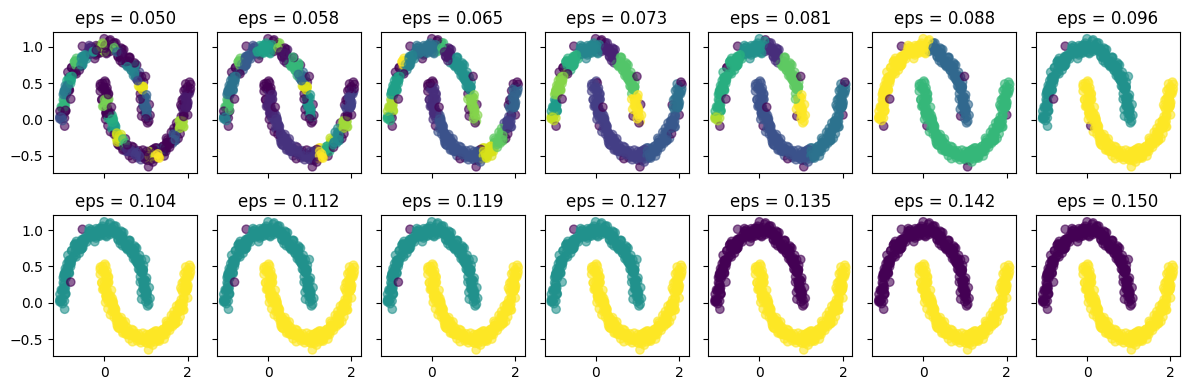

In [1195]:
# Create a list of eps
eps_list = np.linspace(0.05, 0.15, 14)

# Compute number of row and columns
COLUMNS = 7
ROWS = math.ceil(len(eps_list)/COLUMNS)

fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(12, 4), sharey=True, sharex=True)

for i in range(0, len(eps_list)):
    eps = eps_list[i]
    
    current_column = i%COLUMNS
    current_row = i//COLUMNS
    
    ax = axs[current_row, current_column]
    labels = DBSCAN(eps=eps).fit_predict(X_moons)
    ax.scatter(X_moons[:,0], X_moons[:,1], c=labels, alpha=0.6)
    ax.set_title("eps = {:.3f}".format(eps))
    
plt.tight_layout()

In [1196]:
seeds = pd.read_csv("ADA_personal/data/seeds_dataset.csv")
seeds.head()

ID   area  perimeter  compactness  lengthOfKernel  widthOfKernel  \
0   1  15.26      14.84       0.8710           5.763          3.312   
1   2  14.88      14.57       0.8811           5.554          3.333   
2   3  14.29      14.09       0.9050           5.291          3.337   
3   4  13.84      13.94       0.8955           5.324          3.379   
4   5  16.14      14.99       0.9034           5.658          3.562   

   asymmetryCoefficient  lengthOfKernelGroove  seedType  
0                 2.221                 5.220         1  
1                 1.018                 4.956         1  
2                 2.699                 4.825         1  
3                 2.259                 4.805         1  
4                 1.355                 5.175         1

In [1197]:
seeds_features = seeds.drop("ID", axis=1).drop("seedType", axis=1)
seeds_features.head()

area  perimeter  compactness  lengthOfKernel  widthOfKernel  \
0  15.26      14.84       0.8710           5.763          3.312   
1  14.88      14.57       0.8811           5.554          3.333   
2  14.29      14.09       0.9050           5.291          3.337   
3  13.84      13.94       0.8955           5.324          3.379   
4  16.14      14.99       0.9034           5.658          3.562   

   asymmetryCoefficient  lengthOfKernelGroove  
0                 2.221                 5.220  
1                 1.018                 4.956  
2                 2.699                 4.825  
3                 2.259                 4.805  
4                 1.355                 5.175

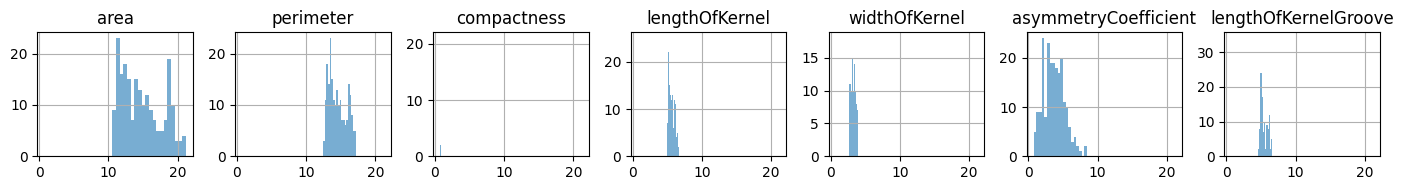

In [1198]:
columns = seeds_features.columns

fig, axs = plt.subplots(1, len(columns), figsize=(14,2), sharex=True)

for column_idx in range(0, len(columns)):
    seeds_features[columns[column_idx]].hist(bins=20, ax=axs[column_idx], alpha=0.6)
    axs[column_idx].set_title(columns[column_idx])
    
plt.tight_layout()

In [1199]:
scaled_features = StandardScaler().fit(seeds_features).transform(seeds_features)
print("Scaled sample: %s" %scaled_features[0])

Scaled sample: [ 1.42097769e-01  2.15462437e-01  6.06017918e-05  3.04218199e-01
  1.41701823e-01 -9.86151745e-01 -3.83577423e-01]


/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The 

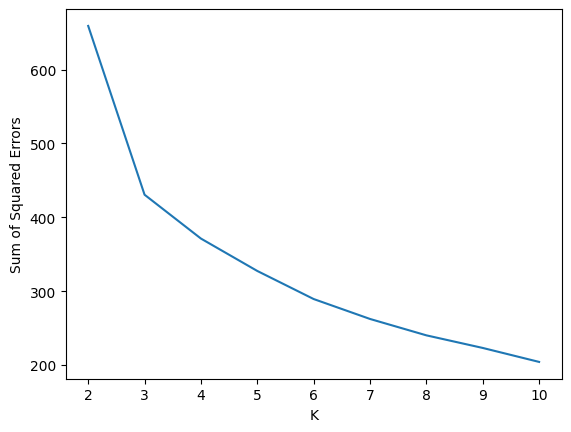

In [1200]:
plot_sse(scaled_features)

In [1201]:
X_reduced_tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=0).fit_transform(scaled_features)

/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'Discovered clusters')

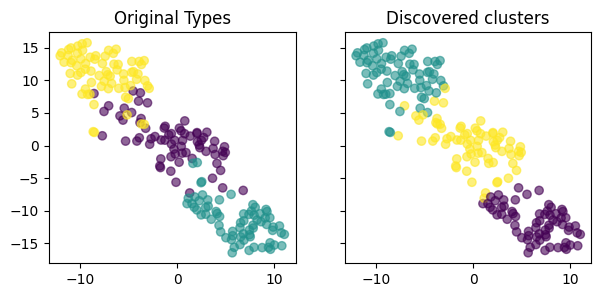

In [1202]:
fig, axs = plt.subplots(1, 2, figsize=(7,3), sharey=True)

axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=seeds.seedType, alpha=0.6)
axs[0].set_title("Original Types")


labels = KMeans(n_clusters=3, random_state=0).fit_predict(scaled_features)

axs[1].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels, alpha=0.6)
axs[1].set_title("Discovered clusters")


In [1203]:
wine = pd.read_csv("ADA_personal/data/wine-clustering.csv")
wine.head()

Alcohol  Malic_Acid   Ash  Ash_Alcanity  Magnesium  Total_Phenols  \
0    14.23        1.71  2.43          15.6        127           2.80   
1    13.20        1.78  2.14          11.2        100           2.65   
2    13.16        2.36  2.67          18.6        101           2.80   
3    14.37        1.95  2.50          16.8        113           3.85   
4    13.24        2.59  2.87          21.0        118           2.80   

   Flavanoids  Nonflavanoid_Phenols  Proanthocyanins  Color_Intensity   Hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   OD280  Proline  
0   3.92     1065  
1   3.40     1050  
2   3.17     1185  
3   3.45     1480  
4   2.93      735

/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The 

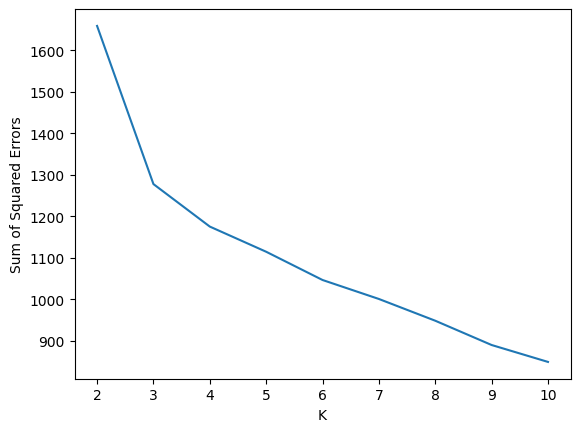

In [1204]:
wine_scaled = StandardScaler().fit(wine).transform(wine)
plot_sse(wine_scaled)

/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'Discovered clusters')

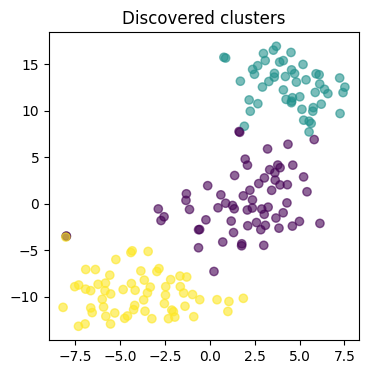

In [1205]:
wine_scaled_reduced_tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=0).fit_transform(wine_scaled)
labels = KMeans(n_clusters=3, random_state=0).fit_predict(wine_scaled)

fig, axs = plt.subplots(1, 1, figsize=(4,4), sharey=True)
axs.scatter(wine_scaled_reduced_tsne[:,0], wine_scaled_reduced_tsne[:,1], c=labels, alpha=0.6)
axs.set_title("Discovered clusters")

/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ada_exam_2024/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The 

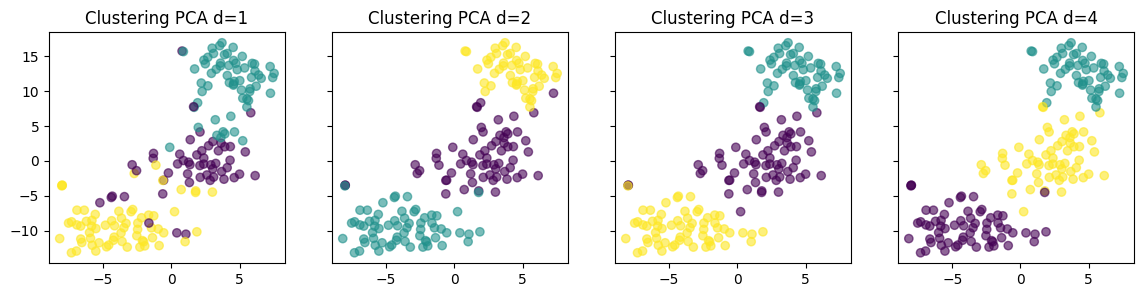

In [1206]:
fig, axs = plt.subplots(1, 4, figsize=(14, 3), sharey=True)

for i in range(0, 4):
    X_reduced_pca = PCA(n_components=i+1).fit(wine_scaled).transform(wine_scaled)
    labels = KMeans(n_clusters=3, random_state=0).fit_predict(X_reduced_pca)
    axs[i].scatter(wine_scaled_reduced_tsne[:,0], wine_scaled_reduced_tsne[:,1], c=labels, alpha=0.6)
    axs[i].set_title("Clustering PCA d=%s"% (i+1))

In [1207]:
nlp = spacy.load('en_core_web_sm')

In [1208]:
corpus_root = 'ADA_personal/data/books/'

In [1209]:
books = list()

for book_file in os.listdir(corpus_root):
    if ".txt" in book_file:
        print(book_file)
        with codecs.open(os.path.join(corpus_root,book_file),encoding="utf8") as f:
            books.append(f.read())

Moby_Dick.txt
Frankenstein.txt
DRACULA.txt
PRIDE_AND_PREJUDICE.txt


In [1210]:
print(books[3][0:600])

PRIDE AND PREJUDICE

By Jane Austen



Chapter 1


It is a truth universally acknowledged, that a single man in possession
of a good fortune, must be in want of a wife.

However little known the feelings or views of such a man may be on his
first entering a neighbourhood, this truth is so well fixed in the minds
of the surrounding families, that he is considered the rightful property
of some one or other of their daughters.

“My dear Mr. Bennet,” said his lady to him one day, “have you heard that
Netherfield Park is let at last?”

Mr. Bennet replied that he had not.

“But it is,” returned she;


In [1211]:
books = [" ".join(b.split()) for b in books]

In [1212]:
print(books[3][0:600])

PRIDE AND PREJUDICE By Jane Austen Chapter 1 It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife. However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters. “My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs.


In [1213]:
#index all books
book = books[1]

#put in raw text, get a Spacy object
doc = nlp(book)

In [1214]:
sentences = [sent for sent in doc.sents]
print('Sentence 1:',sentences[0],'\n')
print('Sentence 2:',sentences[1],'\n')
print('Sentence 3:',sentences[2],'\n')

Sentence 1: Frankenstein, or the Modern Prometheus by Mary Wollstonecraft (Godwin) Shelley Letter 1 St. Petersburgh, Dec. 11th, 17-- TO Mrs. Saville, England You will rejoice to hear that no disaster has accompanied the commencement of an enterprise which you have regarded with such evil forebodings. 

Sentence 2: I arrived here yesterday, and my first task is to assure my dear sister of my welfare and increasing confidence in the success of my undertaking. 

Sentence 3: I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 



In [1215]:
example = 'I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight.'

doc = nlp(example)

#strings are encoded to hashes
tokens = [token.text for token in doc]

print(example,'\n')
print(tokens)

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

['I', 'am', 'already', 'far', 'north', 'of', 'London', ',', 'and', 'as', 'I', 'walk', 'in', 'the', 'streets', 'of', 'Petersburgh', ',', 'I', 'feel', 'a', 'cold', 'northern', 'breeze', 'play', 'upon', 'my', 'cheeks', ',', 'which', 'braces', 'my', 'nerves', 'and', 'fills', 'me', 'with', 'delight', '.']


In [1216]:
pos_tagged = [(token.text, token.pos_) for token in doc]

print(example,'\n')
print(pos_tagged)

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

[('I', 'PRON'), ('am', 'AUX'), ('already', 'ADV'), ('far', 'ADV'), ('north', 'ADV'), ('of', 'ADP'), ('London', 'PROPN'), (',', 'PUNCT'), ('and', 'CCONJ'), ('as', 'SCONJ'), ('I', 'PRON'), ('walk', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('streets', 'NOUN'), ('of', 'ADP'), ('Petersburgh', 'PROPN'), (',', 'PUNCT'), ('I', 'PRON'), ('feel', 'VERB'), ('a', 'DET'), ('cold', 'ADJ'), ('northern', 'ADJ'), ('breeze', 'NOUN'), ('play', 'VERB'), ('upon', 'SCONJ'), ('my', 'PRON'), ('cheeks', 'NOUN'), (',', 'PUNCT'), ('which', 'PRON'), ('braces', 'VERB'), ('my', 'PRON'), ('nerves', 'NOUN'), ('and', 'CCONJ'), ('fills', 'VERB'), ('me', 'PRON'), ('with', 'ADP'), ('delight', 'NOUN'), ('.', 'PUNCT')]


In [1217]:
print(spacy.explain('CCONJ'))
print(spacy.explain('ADP'))
print(spacy.explain('DET'))

coordinating conjunction
adposition
determiner


In [1218]:
pos_tagged = [(token.text, token.tag_) for token in doc]

print(pos_tagged)

[('I', 'PRP'), ('am', 'VBP'), ('already', 'RB'), ('far', 'RB'), ('north', 'RB'), ('of', 'IN'), ('London', 'NNP'), (',', ','), ('and', 'CC'), ('as', 'IN'), ('I', 'PRP'), ('walk', 'VBP'), ('in', 'IN'), ('the', 'DT'), ('streets', 'NNS'), ('of', 'IN'), ('Petersburgh', 'NNP'), (',', ','), ('I', 'PRP'), ('feel', 'VBP'), ('a', 'DT'), ('cold', 'JJ'), ('northern', 'JJ'), ('breeze', 'NN'), ('play', 'VB'), ('upon', 'IN'), ('my', 'PRP$'), ('cheeks', 'NNS'), (',', ','), ('which', 'WDT'), ('braces', 'VBZ'), ('my', 'PRP$'), ('nerves', 'NNS'), ('and', 'CC'), ('fills', 'VBZ'), ('me', 'PRP'), ('with', 'IN'), ('delight', 'NN'), ('.', '.')]


In [1219]:
print(spacy.explain('PRP'))
print(spacy.explain('VBP'))

pronoun, personal
verb, non-3rd person singular present


In [1220]:
print(example,'\n')
for ent in doc.ents:
    print(ent.text, ent.label_)

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

London GPE
Petersburgh GPE


In [1221]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))
print('First ten stop words:',list(spacy_stopwords)[:10])

Number of stop words: 326
First ten stop words: ['over', 'six', 'yours', 'so', 'nobody', 'often', 'ours', 'more', 'whereafter', 'beyond']


In [1222]:
print(example,'\n')

stop_words = [token.text for token in doc if token.is_stop]

print(stop_words)

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

['I', 'am', 'already', 'of', 'and', 'as', 'I', 'in', 'the', 'of', 'I', 'a', 'upon', 'my', 'which', 'my', 'and', 'me', 'with']


In [1223]:
print(example,'\n')
for token in doc:
    if token.text != token.lemma_:
        print(token.text,'--->',token.lemma_)

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

am ---> be
streets ---> street
cheeks ---> cheek
braces ---> brace
nerves ---> nerve
fills ---> fill
me ---> I


In [1224]:
print(example,'\n')

for chunk in doc.noun_chunks:
    print(chunk.text)

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

I
London
I
the streets
Petersburgh
I
my cheeks
which
my nerves
me
delight


In [1225]:
print(example,'\n')

for token in doc:
    print('Token:',token.text,'Head:',token.head.text, 'Children:',[child for child in token.children])

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

Token: I Head: am Children: []
Token: am Head: am Children: [I, already, north, ,, and, feel]
Token: already Head: am Children: []
Token: far Head: north Children: []
Token: north Head: am Children: [far, of]
Token: of Head: north Children: [London]
Token: London Head: of Children: []
Token: , Head: am Children: []
Token: and Head: am Children: []
Token: as Head: walk Children: []
Token: I Head: walk Children: []
Token: walk Head: feel Children: [as, I, in]
Token: in Head: walk Children: [streets]
Token: the Head: streets Children: []
Token: streets Head: in Children: [the, of]
Token: of Head: streets Children: [Petersburgh]
Token: Petersburgh Head: of Children: []
Token: , Head: feel Children: []
Token: I Head: feel Children: []
Token: feel Head: am Children: [walk, ,, I, play, .]
Token: a Head: play Child

In [1226]:
from collections import Counter

print(example,'\n')
words = [token.text for token in doc]

# five most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common()

print(common_words)

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

[('I', 3), (',', 3), ('of', 2), ('and', 2), ('my', 2), ('am', 1), ('already', 1), ('far', 1), ('north', 1), ('London', 1), ('as', 1), ('walk', 1), ('in', 1), ('the', 1), ('streets', 1), ('Petersburgh', 1), ('feel', 1), ('a', 1), ('cold', 1), ('northern', 1), ('breeze', 1), ('play', 1), ('upon', 1), ('cheeks', 1), ('which', 1), ('braces', 1), ('nerves', 1), ('fills', 1), ('me', 1), ('with', 1), ('delight', 1), ('.', 1)]


In [1227]:
words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]

# five most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common()

print(common_words)

[('far', 1), ('north', 1), ('London', 1), ('walk', 1), ('streets', 1), ('Petersburgh', 1), ('feel', 1), ('cold', 1), ('northern', 1), ('breeze', 1), ('play', 1), ('cheeks', 1), ('braces', 1), ('nerves', 1), ('fills', 1), ('delight', 1)]


In [1228]:
nlp = spacy.load('en_core_web_sm')

In [1229]:
nlp.remove_pipe('parser')
nlp.remove_pipe('tagger')

('tagger', <spacy.pipeline.tagger.Tagger at 0x2bc9784c0>)

In [1230]:
G = nx.Graph() # for a directed graph use nx.DiGraph()
G.add_node(1)
G.add_nodes_from(range(2,9))  # add multiple nodes at once

# add edges 
G.add_edge(1,2)
edges = [(2,3), (1,3), (4,1), (4,5), (5,6), (5,7), (6,7), (7,8), (6,8)]
G.add_edges_from(edges)
G.nodes()

NodeView((1, 2, 3, 4, 5, 6, 7, 8))

In [1231]:
print(G)

Graph with 8 nodes and 10 edges


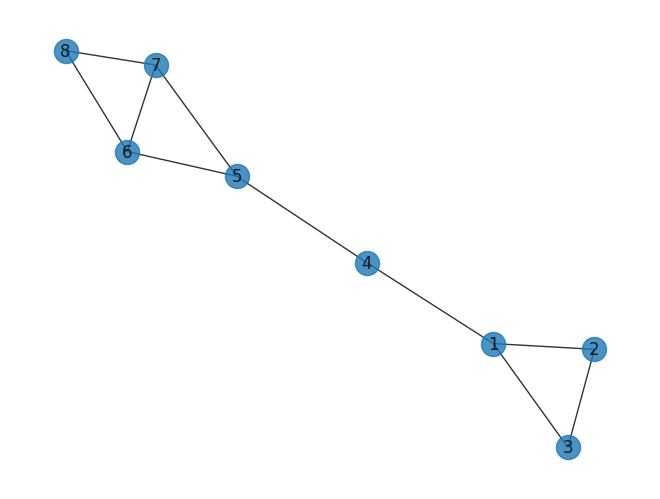

In [1232]:
# plot it out
# for different layouts, please see: https://networkx.github.io/documentation/stable/reference/drawing.html#module-networkx.drawing.layout
nx.draw_spring(G, with_labels=True,  alpha = 0.8)

In [1233]:
# Helper function for plotting the degree distribution of a Graph
def plot_degree_distribution(G):
    degrees = {}
    for node in G.nodes():
        degree = G.degree(node)
        if degree not in degrees:
            degrees[degree] = 0
        degrees[degree] += 1
    sorted_degree = sorted(degrees.items())
    deg = [k for (k,v) in sorted_degree]
    cnt = [v for (k,v) in sorted_degree]
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.ylabel("Frequency")
    plt.xlabel("Degree")
    ax.set_xticks([d+0.05 for d in deg])
    ax.set_xticklabels(deg)

In [1234]:
# Helper function for printing various graph properties
def describe_graph(G):
    print(G)
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

In [1235]:
# Helper function for visualizing the graph
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o'):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='g', node_shape=node_shape)
    plt.axis('off')

Graph with 10 nodes and 20 edges
Avg. Shortest Path Length: 1.6000
Diameter: 3.0000
Sparsity: 0.4444
Global clustering coefficient aka Transitivity: 0.3231


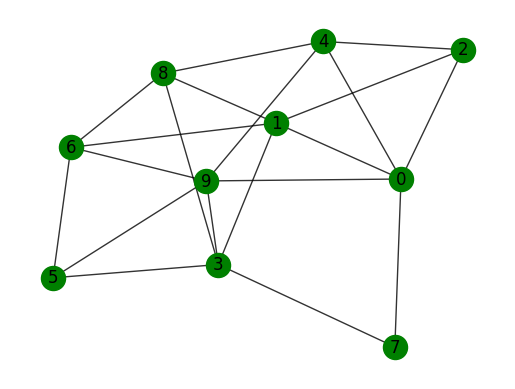

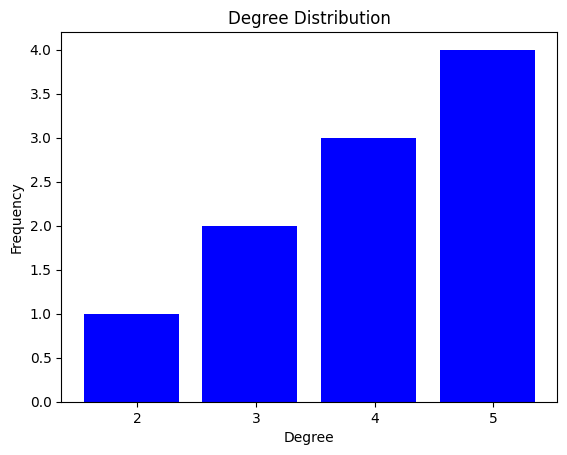

In [1236]:
n = 10  # 10 nodes
m = 20  # 20 edges

erG = nx.gnm_random_graph(n, m)

describe_graph(erG)
visualize_graph(erG, k=0.05, alpha=0.8)
plot_degree_distribution(erG)

Graph named "Zachary's Karate Club" with 34 nodes and 78 edges
Avg. Shortest Path Length: 2.4082
Diameter: 5.0000
Sparsity: 0.1390
Global clustering coefficient aka Transitivity: 0.2557


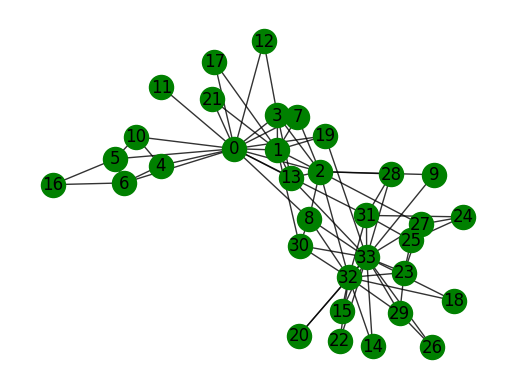

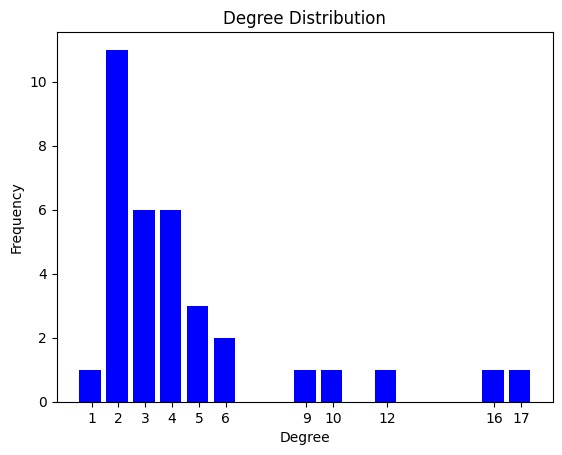

In [1237]:
karateG = nx.karate_club_graph()
describe_graph(karateG)
visualize_graph(karateG, k=0.05, alpha=0.8)
plot_degree_distribution(karateG)

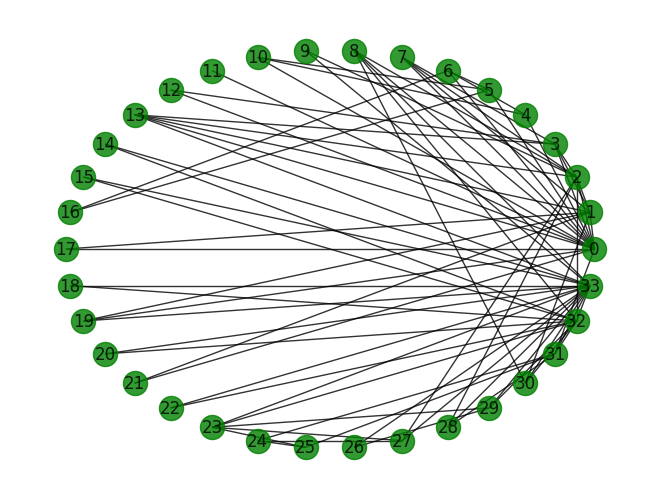

In [1238]:
# Draw the graph with a circular layout instead?
nx.draw_circular(karateG, with_labels=True,  node_color='g', alpha = 0.8)

In [1239]:
data_folder = './ADA_personal/data/quakers/'
nodes = pd.read_csv(data_folder + 'quakers_nodelist.csv')
nodes.head(10)

Name           Historical Significance  Gender  \
0                Joseph Wyeth                  religious writer    male   
1  Alexander Skene of Newtyle       local politician and author    male   
2                 James Logan     colonial official and scholar    male   
3               Dorcas Erbery                   Quaker preacher  female   
4                Lilias Skene          Quaker preacher and poet    male   
5             William Mucklow                  religious writer    male   
6            Thomas Salthouse        Quaker preacher and writer    male   
7            William Dewsbury                   Quaker activist    male   
8                John Audland                   Quaker preacher    male   
9            Richard Claridge  Quaker minister and schoolmaster    male   

   Birthdate  Deathdate        ID  
0       1663       1731  10013191  
1       1621       1694  10011149  
2       1674       1751  10007567  
3       1656       1659  10003983  
4       1626       1697  10011152  
5       1630       1713  10008595  
6       1630       1691  10010643  
7       1621       1688  10003478  
8       1630       1664  10000411  
9       1649       1723  10002469

In [1240]:
nodes.Gender = nodes.Gender.astype('category')
nodes = nodes.rename({'Historical Significance': 'Role'}, axis = 1)
print('There are ', len(nodes), 'quakers')

There are  119 quakers


In [1241]:
nodes['Role'].isna().sum()

2

In [1242]:
# some don't have a known 'historical significance' or 'role'
nodes['Role'].fillna('Unknown', inplace=True)

/var/folders/lx/78bdvyf1797_dxpw5r160s9c0000gn/T/ipykernel_2610/3237002968.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nodes['Role'].fillna('Unknown', inplace=True)


In [1243]:
# check if the names are unique
len(nodes['Name'].unique()) == len(nodes)

True

In [1244]:
# since the names are unique, index based on names
nodes.set_index('Name', inplace=True)

# let's also add a new attribute based on the role column. Is (s)he a directly involved Quaker or not? 
nodes['Quaker'] = ['quaker' in role.lower() for role in nodes.Role]
nodes.head()

Role  Gender  Birthdate  \
Name                                                                           
Joseph Wyeth                             religious writer    male       1663   
Alexander Skene of Newtyle    local politician and author    male       1621   
James Logan                 colonial official and scholar    male       1674   
Dorcas Erbery                             Quaker preacher  female       1656   
Lilias Skene                     Quaker preacher and poet    male       1626   

                            Deathdate        ID  Quaker  
Name                                                     
Joseph Wyeth                     1731  10013191   False  
Alexander Skene of Newtyle       1694  10011149   False  
James Logan                      1751  10007567   False  
Dorcas Erbery                    1659  10003983    True  
Lilias Skene                     1697  10011152    True

In [1245]:
# let's see which quaker knows whom, this will translate into edges in our graph
edges = pd.read_csv(data_folder + 'quakers_edgelist.csv')
edges.head()

Source                                         Target
0  George Keith                                 Robert Barclay
1  George Keith                                 Benjamin Furly
2  George Keith  Anne Conway Viscountess Conway and Killultagh
3  George Keith               Franciscus Mercurius van Helmont
4  George Keith                                   William Penn

In [1246]:
print('There are',len(edges), 'edges')

There are 174 edges


In [1247]:
quakerG =nx.from_pandas_edgelist(edges, 'Source', 'Target', edge_attr=None, create_using= nx.Graph())
describe_graph(quakerG)

Graph with 119 nodes and 174 edges
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0248
Global clustering coefficient aka Transitivity: 0.1694


In [1248]:
# add node attributes by passing dictionary of type name -> attribute
nx.set_node_attributes(quakerG, nodes['Role'].to_dict(), 'Role' )
nx.set_node_attributes(quakerG, nodes['Gender'].to_dict(), 'Gender' )
nx.set_node_attributes(quakerG, nodes['Birthdate'].to_dict(), 'Birthdate' )
nx.set_node_attributes(quakerG, nodes['Deathdate'].to_dict(), 'Deathdate' )
nx.set_node_attributes(quakerG, nodes['Quaker'].to_dict(), 'Quaker' )

In [1249]:
# You can easily get the attributes of a node
quakerG.nodes['William Penn']

{'Role': 'Quaker leader and founder of Pennsylvania',
 'Gender': 'male',
 'Birthdate': 1644,
 'Deathdate': 1718,
 'Quaker': True}

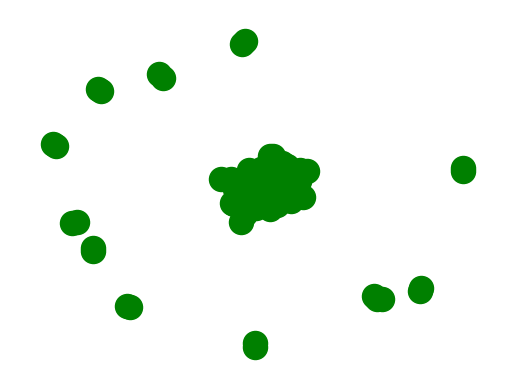

In [1250]:
visualize_graph(quakerG, False, k=0.05, alpha=0.4)

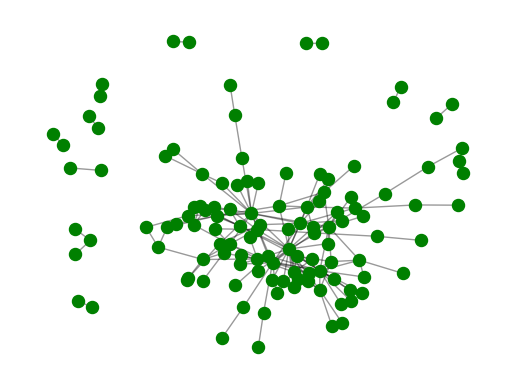

In [1251]:
visualize_graph(quakerG, False, k=0.2, alpha=0.4, node_shape='.')

In [1252]:
# 174 * (2) / ( 119* 118)
print("Network sparsity: %.4f" %nx.density(quakerG))

Network sparsity: 0.0248


In [1253]:
print(nx.is_connected(quakerG))
comp = list(nx.connected_components(quakerG))
print('The graph contains', len(comp), 'connected components')

False
The graph contains 12 connected components


In [1254]:
largest_comp = max(comp, key=len)
percentage_lcc = len(largest_comp)/quakerG.number_of_nodes() * 100
print('The largest component has', len(largest_comp), 'nodes', 'accounting for %.2f'% percentage_lcc, '% of the nodes') 

The largest component has 96 nodes accounting for 80.67 % of the nodes


In [1255]:
fell_whitehead_path = nx.shortest_path(quakerG, source="Margaret Fell", target="George Whitehead")
print("Shortest path between Fell and Whitehead:", fell_whitehead_path)

Shortest path between Fell and Whitehead: ['Margaret Fell', 'George Fox', 'George Whitehead']


In [1256]:
# take the largest component and analyse its diameter = longest shortest-path
lcc_quakerG = quakerG.subgraph(largest_comp)
print("The diameter of the largest connected component is", nx.diameter(lcc_quakerG))
print("The avg shortest path length of the largest connected component is", nx.average_shortest_path_length(lcc_quakerG))

The diameter of the largest connected component is 8
The avg shortest path length of the largest connected component is 3.3789473684210525


In [1257]:
print('%.4f' %nx.transitivity(quakerG))

0.1694


In [1258]:
# Similar measure but for individual nodes called clustering coefficient
print(nx.clustering(quakerG, ['Alexander Parker', 'John Crook']))

{'Alexander Parker': 0.06666666666666667, 'John Crook': 0.8333333333333334}


In [1259]:
# Lets check by looking at the subgraphs induced by Alex and John
subgraph_Alex = quakerG.subgraph(['Alexander Parker']+list(quakerG.neighbors('Alexander Parker')))
subgraph_John = quakerG.subgraph(['John Crook']+list(quakerG.neighbors('John Crook')))

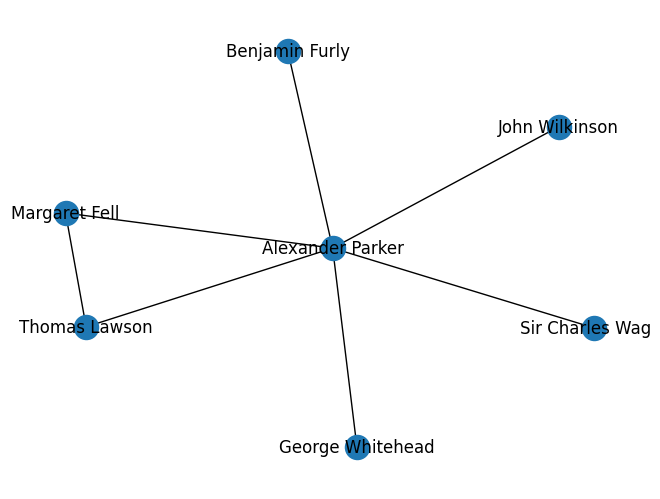

In [1260]:
nx.draw_spring(subgraph_Alex, with_labels=True)

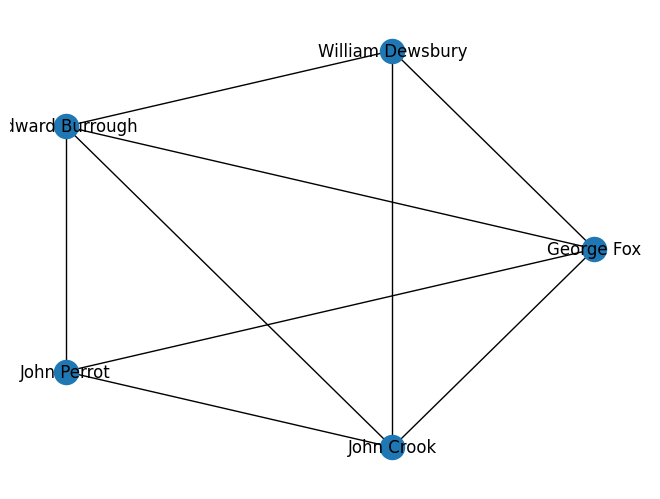

In [1261]:
nx.draw_circular(subgraph_John, with_labels=True)

In [1262]:
degrees = dict(quakerG.degree(quakerG.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)

# And the top 5 most popular quakers are.. 
for quaker, degree in sorted_degree[:5]:
    print(quaker, 'who is', quakerG.nodes[quaker]['Role'], 'knows', degree, 'people')

George Fox who is  a founder of the Religious Society of Friends (Quakers) knows 22 people
William Penn who is Quaker leader and founder of Pennsylvania knows 18 people
James Nayler who is Quaker preacher and writer knows 16 people
George Whitehead who is Quaker leader and writer knows 13 people
Margaret Fell who is Quaker leader knows 13 people


Text(0.5, 1.0, 'Degree distribution for the Quaker network')

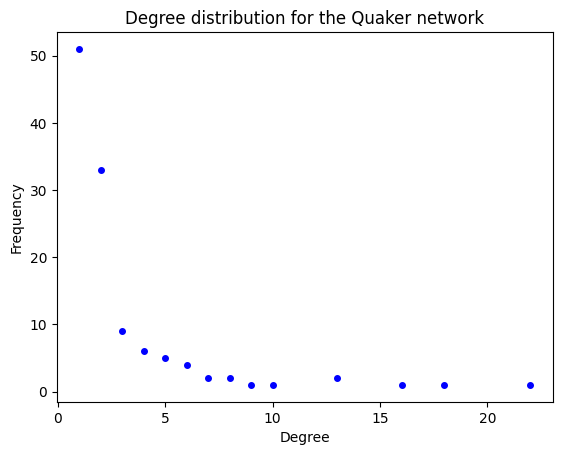

In [1263]:
degree_seq = [d[1] for d in sorted_degree]
degreeCount = collections.Counter(degree_seq)
degreeCount = pd.DataFrame.from_dict( degreeCount, orient='index').reset_index()
fig = plt.figure()
ax = plt.gca()
ax.plot(degreeCount['index'], degreeCount[0], 'o', c='blue', markersize= 4)
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.title('Degree distribution for the Quaker network')

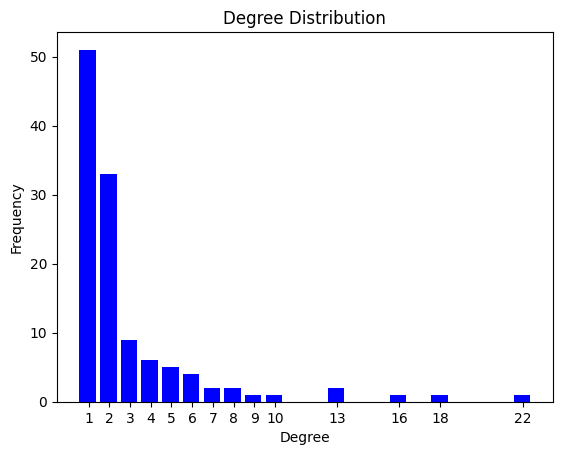

In [1264]:
# As a bar plot
plot_degree_distribution(quakerG)

In [1265]:
degrees = dict(quakerG.degree(quakerG.nodes()))

katz = nx.katz_centrality(quakerG)
nx.set_node_attributes(quakerG, katz, 'katz')
sorted_katz = sorted(katz.items(), key=itemgetter(1), reverse=True)

# And the top 5 most popular quakers are.. 
for quaker, katzc in sorted_katz[:5]:
    print(quaker, 'who is', quakerG.nodes[quaker]['Role'], 'has katz-centrality: %.3f' %katzc)

George Fox who is  a founder of the Religious Society of Friends (Quakers) has katz-centrality: 0.342
James Nayler who is Quaker preacher and writer has katz-centrality: 0.261
William Penn who is Quaker leader and founder of Pennsylvania has katz-centrality: 0.249
George Whitehead who is Quaker leader and writer has katz-centrality: 0.216
Margaret Fell who is Quaker leader has katz-centrality: 0.215


In [1266]:
# Compute betweenness centrality
betweenness = nx.betweenness_centrality(quakerG)
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(quakerG, betweenness, 'betweenness')
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)

for quaker, bw in sorted_betweenness[:5]:
    print(quaker, 'who is', quakerG.nodes[quaker]['Role'], 'has betweeness: %.3f' %bw)

William Penn who is Quaker leader and founder of Pennsylvania has betweeness: 0.240
George Fox who is  a founder of the Religious Society of Friends (Quakers) has betweeness: 0.237
George Whitehead who is Quaker leader and writer has betweeness: 0.126
Margaret Fell who is Quaker leader has betweeness: 0.121
James Nayler who is Quaker preacher and writer has betweeness: 0.104


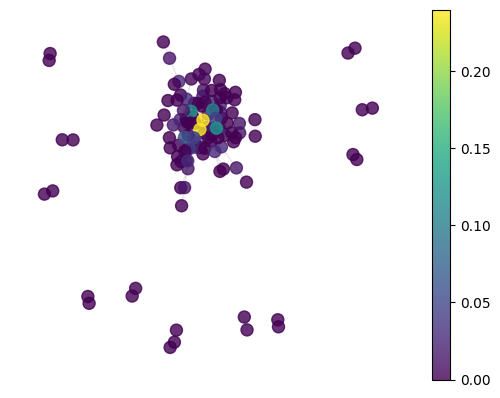

In [1267]:
# similar pattern
list_nodes =list(quakerG.nodes())
list_nodes.reverse()   # for showing the nodes with high betweeness centrality 
pos = nx.spring_layout(quakerG)
ec = nx.draw_networkx_edges(quakerG, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(quakerG, pos, nodelist=list_nodes, node_color=[quakerG.nodes[n]["betweenness"] for n in list_nodes], 
                            alpha=0.8, node_shape = '.')
plt.colorbar(nc)
plt.axis('off')
plt.show()

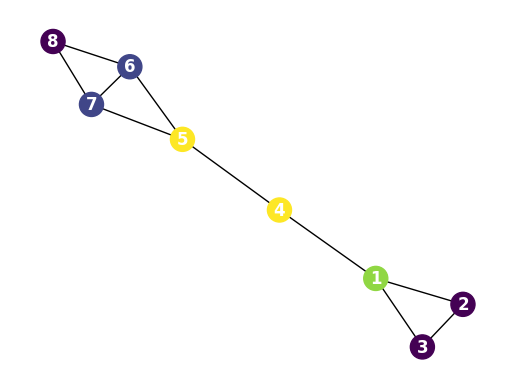

In [1268]:
nx.set_node_attributes(G, nx.betweenness_centrality(G), 'betweenness')
pos = nx.spring_layout(G)
ec = nx.draw_networkx(G, pos, nodelist=G.nodes(),
                         node_color=[G.nodes[n]["betweenness"] for n in G.nodes()], 
                         node_shape = '.', node_size=1200, font_color="white", font_weight="bold")
plt.colorbar(nc)
plt.axis('off')
plt.show()

In [1273]:
comp = girvan_newman(G)
it = 0
for communities in itertools.islice(comp, 4):
    it +=1
    print('Iteration', it)
    print(tuple(sorted(c) for c in communities)) 

Iteration 1
([1, 2, 3, 4], [5, 6, 7, 8])
Iteration 2
([1, 2, 3], [4], [5, 6, 7, 8])
Iteration 3
([1, 2, 3], [4], [5], [6, 7, 8])
Iteration 4
([1], [2, 3], [4], [5], [6, 7, 8])


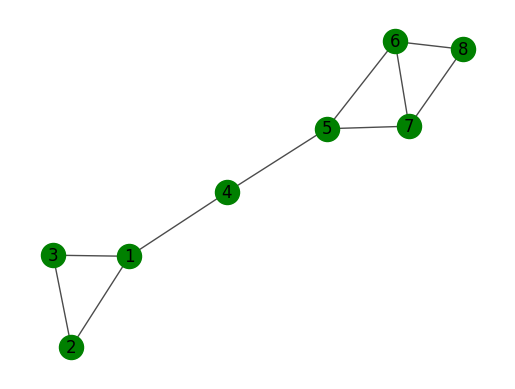

In [1274]:
visualize_graph(G,alpha=0.7)

In [1282]:
# for categorical attributes
nx.attribute_assortativity_coefficient(quakerG, 'Gender')

0.1882377889305155

In [1284]:
nodes.groupby('Gender').size()

/var/folders/lx/78bdvyf1797_dxpw5r160s9c0000gn/T/ipykernel_2610/2517232007.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nodes.groupby('Gender').size()


Gender
female    22
male      97
dtype: int64

In [1286]:
# for numerical attributes, values must be integers
nx.numeric_assortativity_coefficient(quakerG, 'Deathdate')

0.5841284189309789